# HPT PyTorch Lightning: Diabetes

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.

This chapter describes the hyperparameter tuning of a `PyTorch Lightning` network on the Diabetes data set. This is a PyTorch Dataset for regression. A toy data set from scikit-learn. Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients,  as well as the response of interest, a quantitative measure of disease progression one year after baseline.


## Step 1: Setup {#sec-setup-31}

* Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, etc. 
* The parameter `MAX_TIME` specifies the maximum run time in seconds.
* The parameter `INIT_SIZE` specifies the initial design size.
* The parameter `WORKERS` specifies the number of workers. 
* The prefix `PREFIX` is used for the experiment name and the name of the log file.
* The parameter `DEVICE` specifies the device to use for training.


In [1]:
from spotPython.utils.device import getDevice
from math import inf

MAX_TIME = 1
FUN_EVALS = inf
INIT_SIZE = 5
WORKERS = 0
PREFIX="031"
DEVICE = getDevice()
DEVICES = 1
TEST_SIZE = 0.1
TORCH_METRIC = "mean_squared_error"

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
* `WORKERS` is set to 0 for demonstration purposes. For real experiments, this should be increased. See the warnings that are printed when the number of workers is set to 0.

:::

::: {.callout-note}
### Note: Device selection

* Although there are no .cuda() or .to(device) calls required, because Lightning does these for you, see 
[LIGHTNINGMODULE](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), we would like to know which device is used. Threrefore, we imitate the LightningModule behaviour which selects the highest device. 
* The method `spotPython.utils.device.getDevice()` returns the device that is used by Lightning.
:::


## Step 2: Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process.


In [2]:
from spotPython.utils.init import fun_control_init
import numpy as np
fun_control = fun_control_init(
    _L_in=10,
    _L_out=1,
    _torchmetric=TORCH_METRIC,
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    device=DEVICE,
    enable_progress_bar=False,
    fun_evals=FUN_EVALS,
    log_level=10,
    max_time=MAX_TIME,
    num_workers=WORKERS,
    show_progress=True,
    test_size=0.1,
    tolerance_x=np.sqrt(np.spacing(1)),
    )

Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_04_21_14_16_14
Created spot_tensorboard_path: runs/spot_logs/031_p040025_2024-04-21_14-16-14 for SummaryWriter()


## Step 3: Loading the Diabetes Data Set


In [3]:
from spotPython.hyperparameters.values import set_control_key_value
from spotPython.data.diabetes import Diabetes
dataset = Diabetes()
set_control_key_value(control_dict=fun_control,
                        key="data_set",
                        value=dataset,
                        replace=True)
print(len(dataset))
print(dataset.names)

442
['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']


::: {.callout-note}
### Note: Data Set and Data Loader

* As shown below, a DataLoader from `torch.utils.data` can be used to check the data.


In [4]:
# Set batch size for DataLoader
batch_size = 5
# Create DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print(f"Inputs Shape: {inputs.shape}")
    print(f"Targets Shape: {targets.shape}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break

Batch Size: 5
Inputs Shape: torch.Size([5, 10])
Targets Shape: torch.Size([5])
---------------
Inputs: tensor([[ 0.0381,  0.0507,  0.0617,  0.0219, -0.0442, -0.0348, -0.0434, -0.0026,
          0.0199, -0.0176],
        [-0.0019, -0.0446, -0.0515, -0.0263, -0.0084, -0.0192,  0.0744, -0.0395,
         -0.0683, -0.0922],
        [ 0.0853,  0.0507,  0.0445, -0.0057, -0.0456, -0.0342, -0.0324, -0.0026,
          0.0029, -0.0259],
        [-0.0891, -0.0446, -0.0116, -0.0367,  0.0122,  0.0250, -0.0360,  0.0343,
          0.0227, -0.0094],
        [ 0.0054, -0.0446, -0.0364,  0.0219,  0.0039,  0.0156,  0.0081, -0.0026,
         -0.0320, -0.0466]])
Targets: tensor([151.,  75., 141., 206., 135.])


:::
## Step 4: Preprocessing {#sec-preprocessing-31}

Preprocessing is handled by `Lightning` and `PyTorch`. It is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. Here you can find information about the `transforms` methods.

## Step 5: Select the Core Model (`algorithm`) and `core_model_hyper_dict` {#sec-selection-of-the-algorithm-31}

`spotPython` includes the `NetLightRegression` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/netlightregression.py) for configurable neural networks. 
The class is imported here. It inherits from the class `Lightning.LightningModule`, which is the base class for all models in `Lightning`. `Lightning.LightningModule` is a subclass of `torch.nn.Module` and provides additional functionality for the training and testing of neural networks. The class `Lightning.LightningModule` is described in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

* Here we simply add the NN Model to the fun_control dictionary by calling the function `add_core_model_to_fun_control`:


In [5]:
from spotPython.light.regression.netlightregression import NetLightRegression
from spotPython.hyperdict.light_hyper_dict import LightHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=NetLightRegression,
                              hyper_dict=LightHyperDict)

The hyperparameters of the model are specified in the `core_model_hyper_dict` dictionary [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperdict/light_hyper_dict.json).



## Step 6: Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-hyperparameters-31}

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. 

::: {.callout-caution}
### Caution: Small number of epochs for demonstration purposes

* `epochs` and `patience` are set to small values for demonstration purposes. These values are too small for a real application.
* More resonable values are, e.g.:
  * `set_control_hyperparameter_value(fun_control, "epochs", [7, 9])` and
  * `set_control_hyperparameter_value(fun_control, "patience", [2, 7])`
:::


In [6]:
from spotPython.hyperparameters.values import set_control_hyperparameter_value

set_control_hyperparameter_value(fun_control, "l1", [4, 6])
set_control_hyperparameter_value(fun_control, "epochs", [9, 10])
set_control_hyperparameter_value(fun_control, "batch_size", [4, 5])
set_control_hyperparameter_value(fun_control, "optimizer", [
                "Adadelta",
                "Adagrad",
                "Adam",
                "AdamW",
                "Adamax",
                "NAdam",
                "RAdam",
                "RMSprop",
                "Rprop"
            ])
set_control_hyperparameter_value(fun_control, "dropout_prob", [0.01, 0.1])
set_control_hyperparameter_value(fun_control, "lr_mult", [0.5, 5.0])
set_control_hyperparameter_value(fun_control, "patience", [5, 7])
set_control_hyperparameter_value(fun_control, "act_fn",[
                "Sigmoid",
                "ReLU",
                "LeakyReLU",
                "Swish"
            ] )

Setting hyperparameter l1 to value [4, 6].
Variable type is int.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter epochs to value [9, 10].
Variable type is int.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter batch_size to value [4, 5].
Variable type is int.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter optimizer to value ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'NAdam', 'RAdam', 'RMSprop', 'Rprop'].
Variable type is factor.
Core type is str.
Calling modify_hyper_parameter_levels().
Setting hyperparameter dropout_prob to value [0.01, 0.1].
Variable type is float.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter lr_mult to value [0.5, 5.0].
Variable type is float.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter patience to value [5, 7].
Variable type is int.
Core type is None.
Calling modify_hyper_paramet

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/utils/eda.py) generates a design table as follows:


In [7]:
#| fig-cap: Experimental design for the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |    4    |     6   | transform_power_2_int |
| epochs         | int    | 4         |    9    |    10   | transform_power_2_int |
| batch_size     | int    | 4         |    4    |     5   | transform_power_2_int |
| act_fn         | factor | ReLU      |    0    |     3   | None                  |
| optimizer      | factor | SGD       |    0    |     8   | None                  |
| dropout_prob   | float  | 0.01      |    0.01 |     0.1 | None                  |
| lr_mult        | float  | 1.0       |    0.5  |     5   | None                  |
| patience       | int    | 2         |    5    |     7   | transform_power_2_int |
| initialization | factor | Default   |    0    |     2   | None                  |


This allows to check if all information is available and if the information is correct.

::: {.callout-note}
### Note: Hyperparameters of the Tuned Model and the `fun_control` Dictionary
The updated `fun_control` dictionary can be shown with the command `fun_control["core_model_hyper_dict"]`.
:::


## Step 7: Data Splitting, the Objective (Loss) Function and the Metric

### Evaluation  {#sec-selection-of-target-function-31}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set
2. the loss function (and a metric).

::: {.callout-caution}
### Caution: Data Splitting in Lightning

The data splitting is handled by `Lightning`.

:::

### Loss Function {#sec-loss-function-31}

The loss function is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py)
We will use MSE.

### Metric {#sec-metric-31}

* Similar to the loss function, the metric is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py).

::: {.callout-caution}
### Caution: Loss Function and Metric in Lightning

* The loss function and the metric are not hyperparameters that can be tuned with `spotPython`.
* They are handled by `Lightning`.

:::


## Step 8: Calling the SPOT Function

### Preparing the SPOT Call {#sec-prepare-spot-call-31}


In [8]:
from spotPython.utils.init import design_control_init, surrogate_control_init
design_control = design_control_init(init_size=INIT_SIZE)

surrogate_control = surrogate_control_init(noise=True,
                                            n_theta=2)

::: {.callout-note}
### Note: Modifying Values in the Control Dictionaries

* The values in the control dictionaries can be modified with the function `set_control_key_value` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperparameters/values.py), for example:



```{raw}
set_control_key_value(control_dict=surrogate_control,
                        key="noise",
                        value=True,
                        replace=True)
set_control_key_value(control_dict=surrogate_control,
                        key="n_theta",
                        value=2,
                        replace=True)

```


:::

### The Objective Function `fun` {#sec-the-objective-function-31}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotPython`.


In [9]:
from spotPython.fun.hyperlight import HyperLight
fun = HyperLight(log_level=50).fun

### Starting the Hyperparameter Tuning {#sec-call-the-hyperparameter-tuner-31}

The `spotPython` hyperparameter tuning is started by calling the `Spot` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py).


In [10]:
from spotPython.spot import spot
spot_tuner = spot.Spot(fun=fun,
                       fun_control=fun_control,
                       design_control=design_control,
                       surrogate_control=surrogate_control)
spot_tuner.run()

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2524.378173828125     │
│         val_loss          │     2524.378173828125     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [32, 10] | [32, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


train_model result: {'val_loss': 2524.378173828125, 'hp_metric': 2524.378173828125}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2842.787841796875     │
│         val_loss          │     2842.787841796875     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.3 K  | [16, 10] | [16, 1]  
-------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


train_model result: {'val_loss': 2842.787841796875, 'hp_metric': 2842.787841796875}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3312.364501953125     │
│         val_loss          │     3312.364501953125     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.3 K  | [16, 10] | [16, 1]  
-------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


train_model result: {'val_loss': 3312.364501953125, 'hp_metric': 3312.364501953125}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      5119.1201171875      │
│         val_loss          │      5119.1201171875      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [32, 10] | [32, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


train_model result: {'val_loss': 5119.1201171875, 'hp_metric': 5119.1201171875}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │       2722.57421875       │
│         val_loss          │       2722.57421875       │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 2722.57421875, 'hp_metric': 2722.57421875}


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2599.581298828125     │
│         val_loss          │     2599.581298828125     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 2599.581298828125, 'hp_metric': 2599.581298828125}


spotPython tuning: 2524.378173828125 [##########] 98.42% 


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2529.920166015625     │
│         val_loss          │     2529.920166015625     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 2529.920166015625, 'hp_metric': 2529.920166015625}


spotPython tuning: 2524.378173828125 [##########] 100.00% Done...



{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '031',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': 10,
 '_L_out': 1,
 '_torchmetric': 'mean_squared_error',
 'accelerator': 'auto',
 'converters': None,
 'core_model': <class 'spotPython.light.regression.netlightregression.NetLightRegression'>,
 'core_model_hyper_dict': {'act_fn': {'class_name': 'spotPython.torch.activation',
                                      'core_model_parameter_type': 'instance()',
                                      'default': 'ReLU',
                                      'levels': ['Sigmoid',
                                                 'ReLU',
                                                 'LeakyReLU',
                                                 'Swish'],
                                      'lower': 0,
                                      'transform': 'None',
                                      'type': 'factor',
                           

## Step 9: Tensorboard {#sec-tensorboard-31}

The textual output shown in the console (or code cell) can be visualized with Tensorboard.



```{raw}
tensorboard --logdir="runs/"
```



Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.

## Load the saved experiment and get the hyperparameters (tuned architecture)


In [11]:
from spotPython.utils.file import load_experiment
import pprint
PREFIX="031"
experiment_name = "spot_" + PREFIX + "_experiment.pickle"
spot_tuner, fun_control, design_control, surrogate_control, optimizer_control = load_experiment(experiment_name)
from spotPython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': ReLU(),
 'batch_size': 32,
 'dropout_prob': 0.04938229888019609,
 'epochs': 1024,
 'initialization': 'Default',
 'l1': 64,
 'lr_mult': 2.3689895017756495,
 'optimizer': 'AdamW',
 'patience': 64}


## Step 10: Results {#sec-results-31}

After the hyperparameter tuning run is finished, the results can be analyzed.


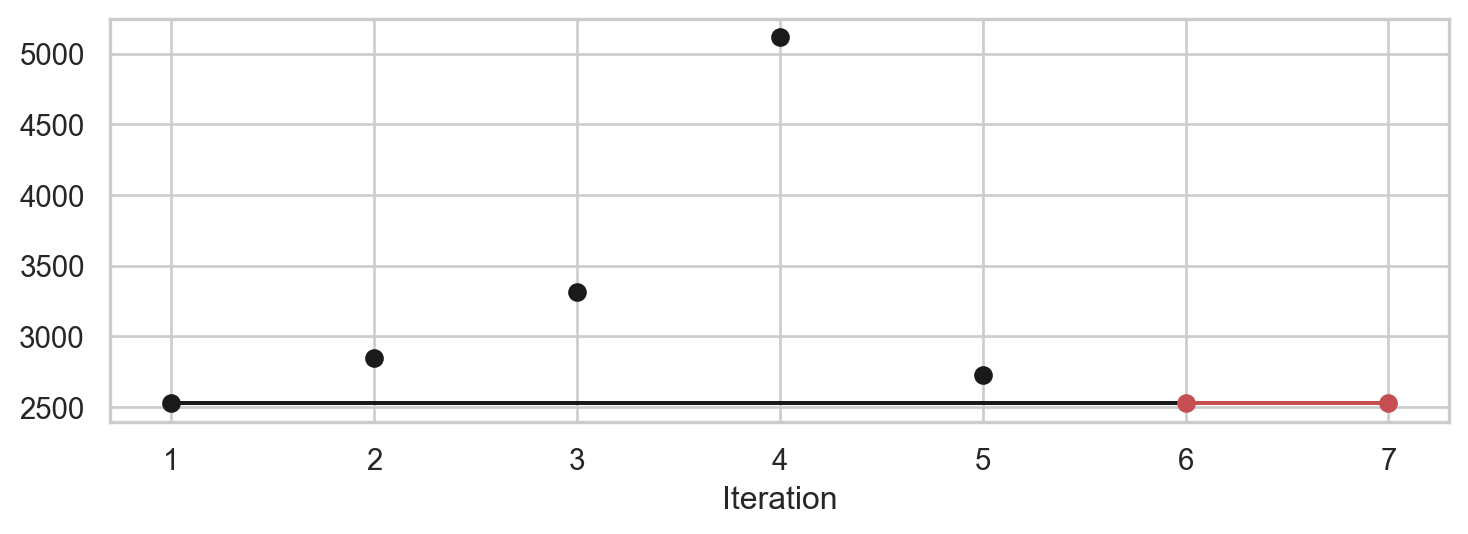

In [12]:
#| fig-cap: Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization.
spot_tuner.plot_progress(log_y=False)

In [13]:
#| fig-cap: Results of the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper | tuned               | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|---------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     4.0 |     6.0 | 6.0                 | transform_power_2_int |         0.05 |         |
| epochs         | int    | 4         |     9.0 |    10.0 | 10.0                | transform_power_2_int |         0.10 |         |
| batch_size     | int    | 4         |     4.0 |     5.0 | 5.0                 | transform_power_2_int |         0.34 | .       |
| act_fn         | factor | ReLU      |     0.0 |     3.0 | ReLU                | None                  |       100.00 | ***     |
| optimizer      | factor | SGD       |     0.0 |     8.0 | AdamW               | None                  |         0.65 | .       |
| dropout_prob   | float  | 0.01      |    0.01 |     0.1 | 0.04938229888019609 | N

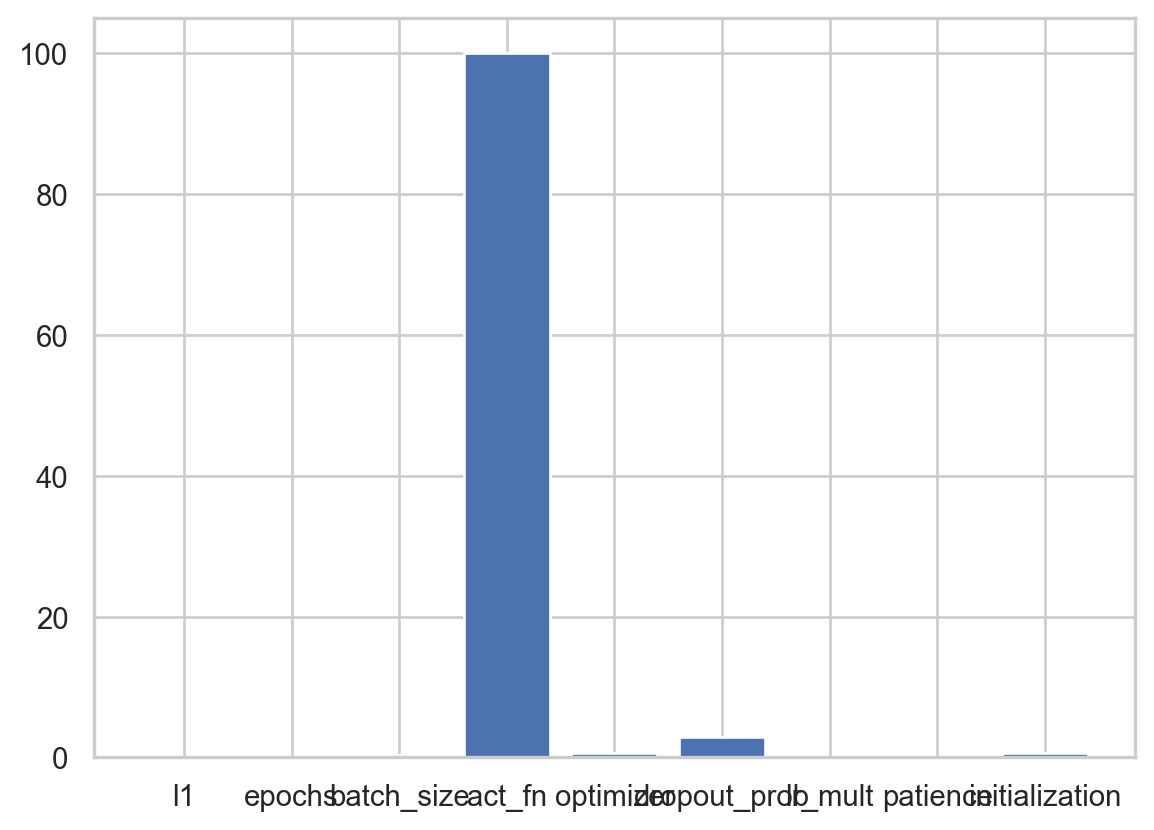

In [14]:
#| fig-cap: 'Variable importance plot, threshold 0.025.'
spot_tuner.plot_importance(threshold=0.025)

### Contour Plots of the Hyperparameters


l1:  0.04731476492847286
epochs:  0.09628464448638081
batch_size:  0.34465339230674585
act_fn:  100.0
optimizer:  0.6512648676234221
dropout_prob:  2.8944602929074215
lr_mult:  0.04731476492847286
patience:  0.04731476492847286
initialization:  0.6553126957437925
impo: [['l1', 0.04731476492847286], ['epochs', 0.09628464448638081], ['batch_size', 0.34465339230674585], ['act_fn', 100.0], ['optimizer', 0.6512648676234221], ['dropout_prob', 2.8944602929074215], ['lr_mult', 0.04731476492847286], ['patience', 0.04731476492847286], ['initialization', 0.6553126957437925]]
indices: [3, 5, 8, 4, 2, 1, 0, 6, 7]
indices after max_imp selection: [3, 5, 8]


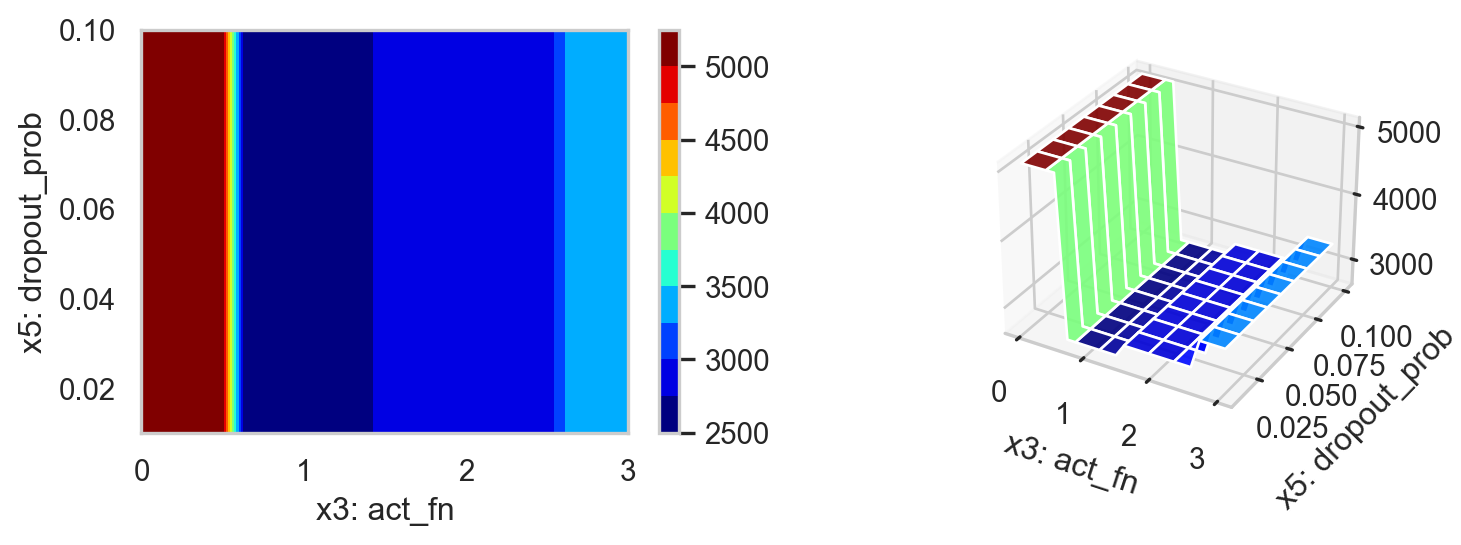

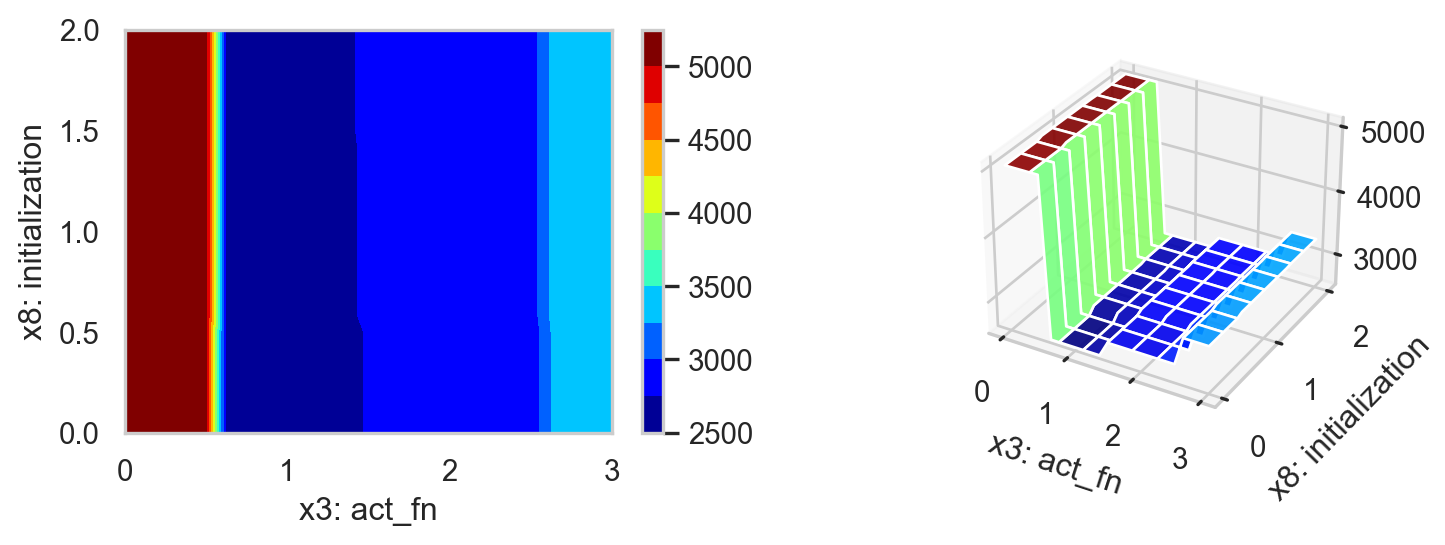

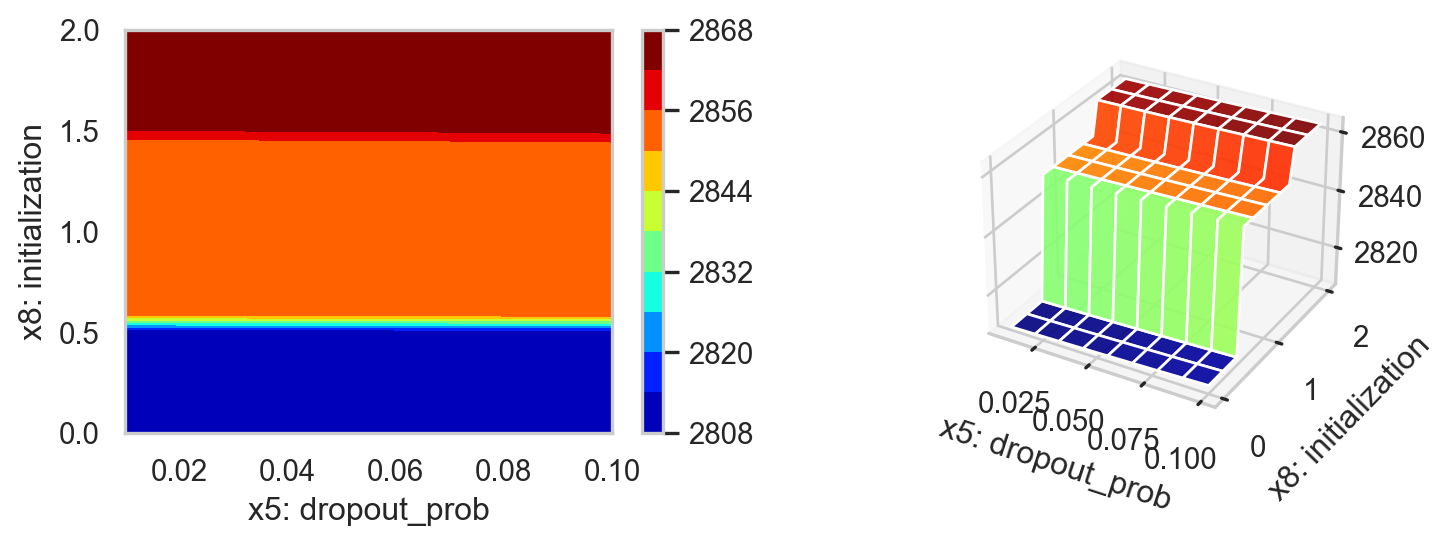

In [15]:
#| fig-cap: Contour plots.
filename = None
spot_tuner.plot_important_hyperparameter_contour(filename=filename, max_imp=3)

### Parallel Coordinates Plot


In [16]:
#| fig-cap: Parallel coordinates plots
spot_tuner.parallel_plot()

### Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/cvmodel.py).


In [17]:
from spotPython.light.cvmodel import cv_model
from spotPython.hyperparameters.values import set_control_key_value
set_control_key_value(control_dict=fun_control,
                        key="k_folds",
                        value=2,
                        replace=True)
set_control_key_value(control_dict=fun_control,
                        key="test_size",
                        value=0.6,
                        replace=True)
cv_model(config, fun_control)

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


k: 0
Train Dataset Size: 221
Val Dataset Size: 221


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      2927.0693359375      │
│         val_loss          │      2927.0693359375      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory runs/lightning_logs/20240421141859490973_64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_CV/checkpoints exists and is not empty.

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


train_model result: {'val_loss': 2927.0693359375, 'hp_metric': 2927.0693359375}
k: 1
Train Dataset Size: 221
Val Dataset Size: 221


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3023.33056640625      │
│         val_loss          │     3023.33056640625      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3023.33056640625, 'hp_metric': 3023.33056640625}


2975.199951171875

## Test on the full data set


In [18]:
from spotPython.light.testmodel import test_model
test_model(config, fun_control)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.16, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 71


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TEST/last.ckpt


Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TEST/last.ckpt


LightDataModule.setup(): stage: TrainerFn.TESTING
test_size: 0.6 used for test dataset.
LightDataModule.test_dataloader(). Test set size: 266


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3241.371826171875     │
│         val_loss          │     3241.371826171875     │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 3241.371826171875, 'hp_metric': 3241.371826171875}


(3241.371826171875, 3241.371826171875)

## Load the last model


In [19]:
from spotPython.light.loadmodel import load_light_from_checkpoint
model_loaded = load_light_from_checkpoint(config, fun_control)

config: {'l1': 64, 'epochs': 1024, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'AdamW', 'dropout_prob': 0.04938229888019609, 'lr_mult': 2.3689895017756495, 'patience': 64, 'initialization': 'Default'}
Loading model with 64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TEST from runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TEST/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )

## Attributions


In [20]:
from spotPython.utils.file import load_experiment
from spotPython.hyperparameters.values import get_tuned_architecture
from spotPython.plot.xai import get_attributions, plot_attributions

spot_tuner, fun_control, design_control, surrogate_control, optimizer_control = load_experiment("spot_031_experiment.pickle")
config = get_tuned_architecture(spot_tuner, fun_control)
feature_names = fun_control["data_set"].names

### Integrated Gradients


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2499.503173828125     │
│         val_loss          │     2499.503173828125     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 2499.503173828125, 'hp_metric': 2499.503173828125}
config: {'l1': 64, 'epochs': 1024, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'AdamW', 'dropout_prob': 0.04938229888019609, 'lr_mult': 2.3689895017756495, 'patience': 64, 'initialization': 'Default'}
Loading model with 64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN from runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888

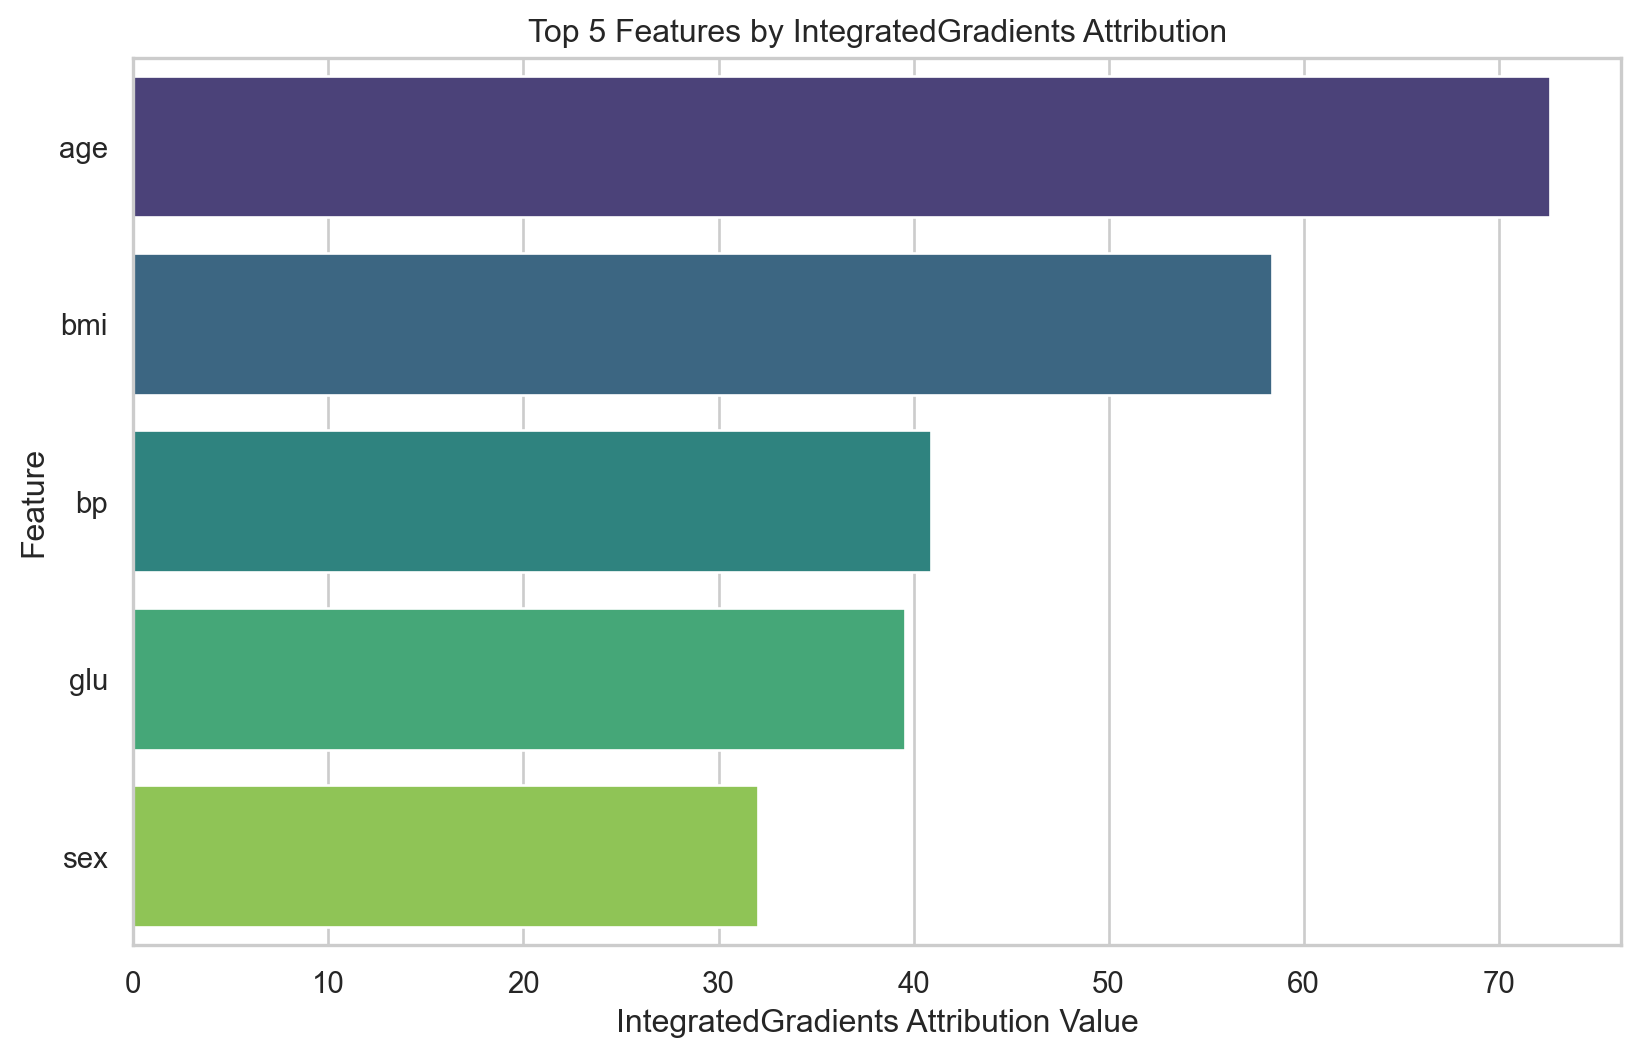

In [21]:
df = get_attributions(spot_tuner, fun_control, feature_names=feature_names, attr_method="IntegratedGradients")
print(df)
plot_attributions(df)

### Deep Lift


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN exists and is not empty.

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2459.909423828125     │
│         val_loss          │     2459.909423828125     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 2459.909423828125, 'hp_metric': 2459.909423828125}
config: {'l1': 64, 'epochs': 1024, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'AdamW', 'dropout_prob': 0.04938229888019609, 'lr_mult': 2.3689895017756495, 'patience': 64, 'initialization': 'Default'}
Loading model with 64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN from runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning:

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished



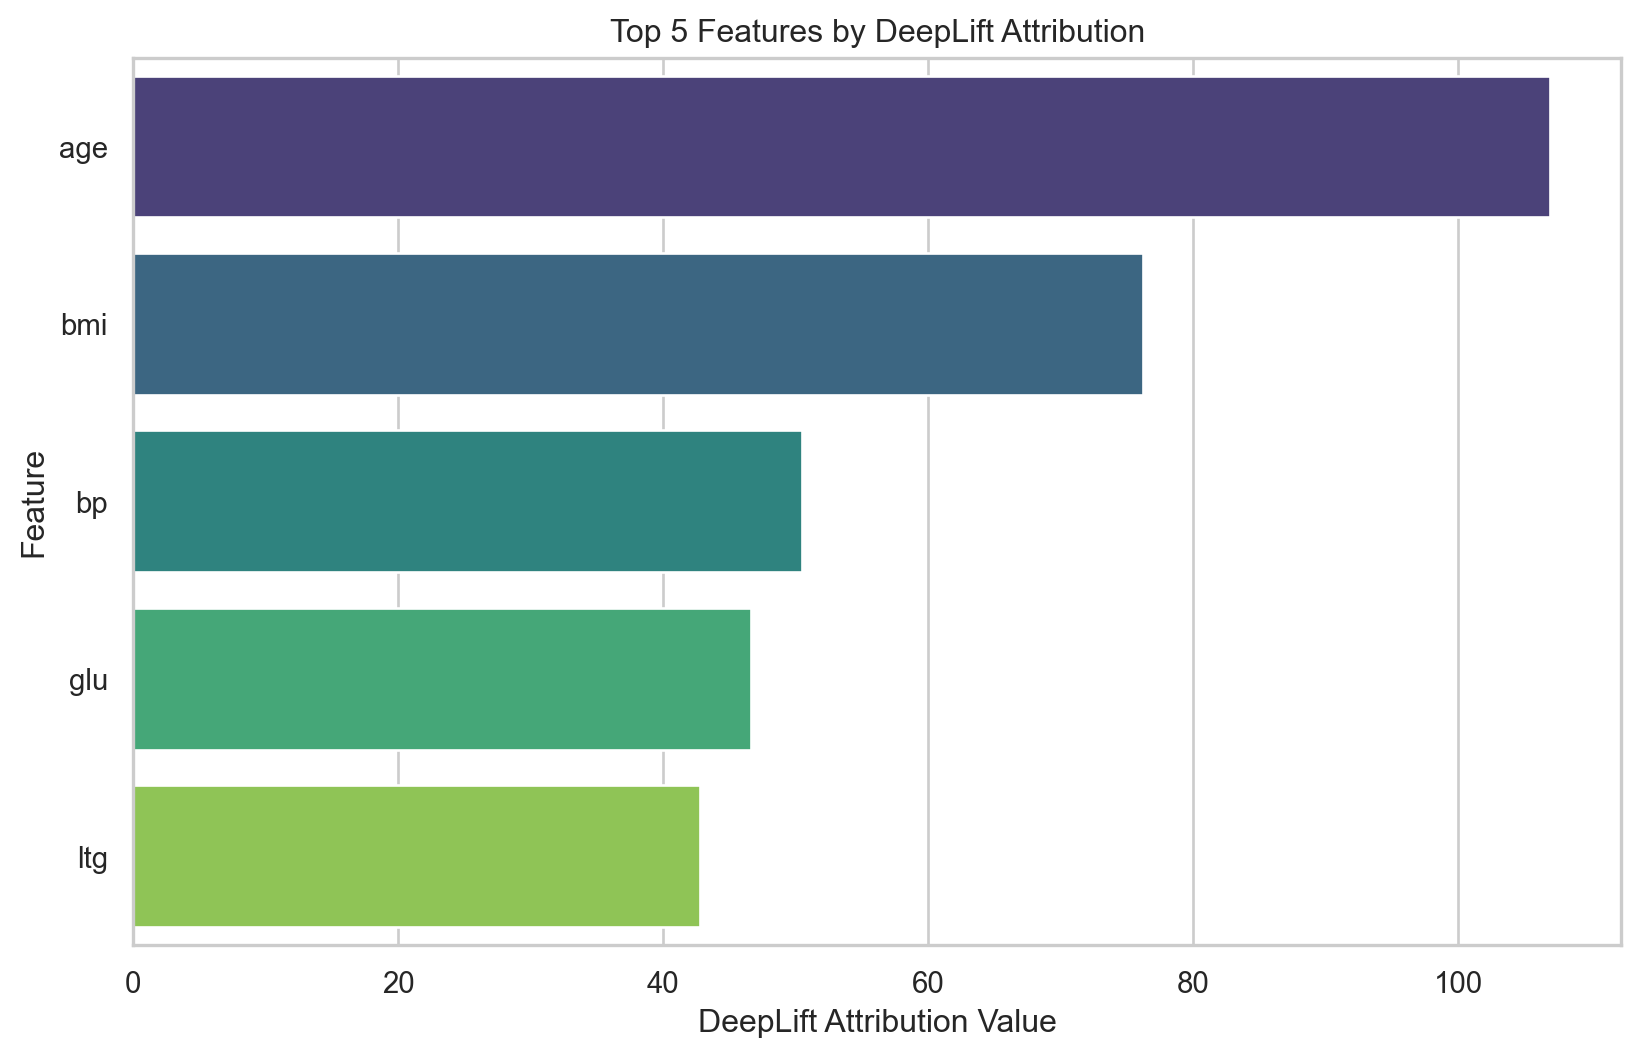

In [22]:
df = get_attributions(spot_tuner, fun_control, feature_names=feature_names, attr_method="DeepLift")
print(df)
plot_attributions(df,  attr_method="DeepLift")

### Feature Ablation


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN exists and is not empty.

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.81, val_size: 0.09 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 39
LightDataModule.train_dataloader(). data_train size: 359


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 39


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      2743.5048828125      │
│         val_loss          │      2743.5048828125      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 2743.5048828125, 'hp_metric': 2743.5048828125}
config: {'l1': 64, 'epochs': 1024, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'AdamW', 'dropout_prob': 0.04938229888019609, 'lr_mult': 2.3689895017756495, 'patience': 64, 'initialization': 'Default'}
Loading model with 64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN from runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.049382298880196

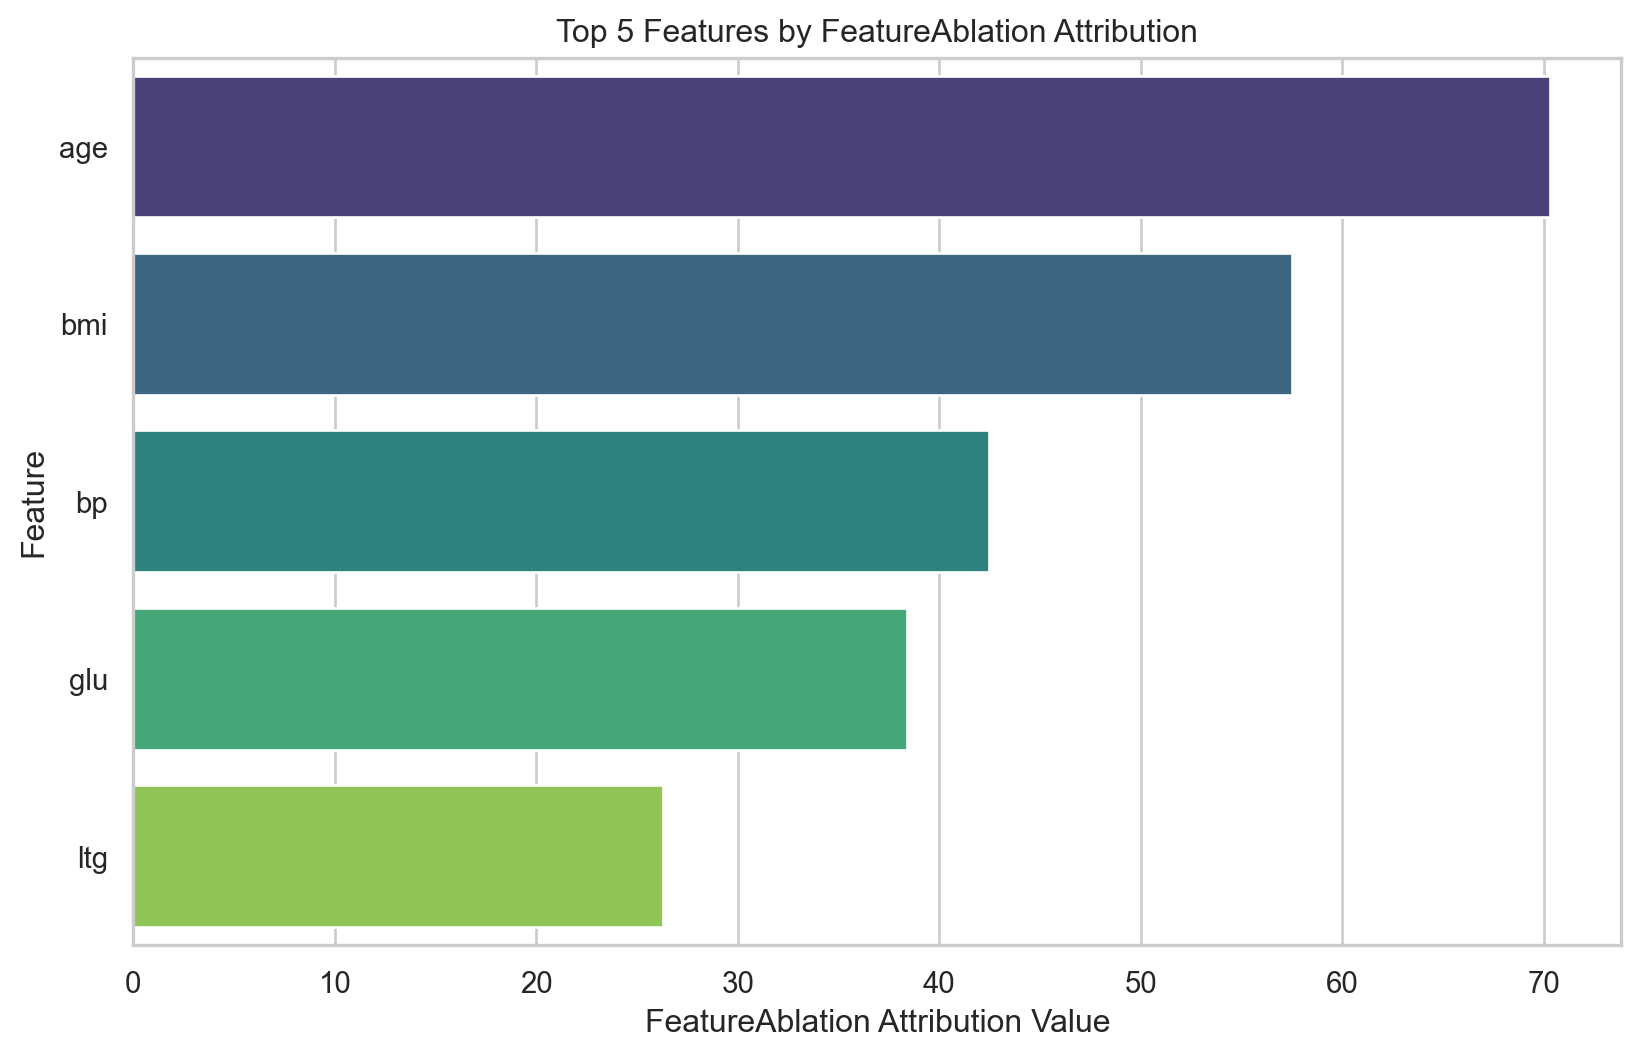

In [23]:
df = get_attributions(spot_tuner, fun_control, feature_names=feature_names, attr_method="FeatureAblation")
print(df)
plot_attributions(df, attr_method="FeatureAblation")

## Visualizing the Activations, Weights, and Gradients

In neural networks, activations, weights, and gradients are fundamental concepts that play different.

1. Activations:

   Activations refer to the outputs of neurons after applying an activation function. In neural networks, the input passes through each neuron of the network layers, where each unit calculates a weighted sum of its inputs and then applies a non-linear activation function (such as ReLU, Sigmoid, or Tanh). These activation functions help introduce non-linearity into the model, enabling the neural network to learn complex relationships between the input data and the predictions. In short, activations are the outputs that are forwarded by the neurons after applying the activation function.

2. Weights:

   Weights are parameters within a neural network that control the strength of the connection between two neurons in successive layers. They are adjusted during the training process to enable the neural network to perform the desired task as well as possible. Each input is multiplied by a weight, and the neural network learns by adjusting these weights based on the error between the predictions and the actual values. Adjusting the weights allows the network to recognize patterns and relationships in the input data and use them for predictions or classifications.

3. Gradients:

   In the context of machine learning and specifically in neural networks, gradients are a measure of the rate of change or the slope of the loss function (a function that measures how well the network performs in predicting the desired output) with respect to the weights. During the training process, the goal is to minimize the value of the loss function to improve the model’s performance. The gradients indicate the direction and size of the steps that need to be taken to adjust the weights in a way that minimizes the loss (known as gradient descent). By repeatedly adjusting the weights in the opposite direction of the gradient, the network can be effectively trained to improve its prediction accuracy.

::: {.callout-note}
### Reference:

* The following code is based on [[PyTorch Lightning TUTORIAL 2: ACTIVATION FUNCTIONS]](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/02-activation-functions.html), Author: Phillip Lippe, License: [[CC BY-SA]](https://creativecommons.org/licenses/by-sa/3.0/), Generated: 2023-03-15T09:52:39.179933.

:::

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh? To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:


In [24]:
from spotPython.plot.xai import (get_activations, get_gradients, get_weights, plot_nn_values_hist, plot_nn_values_scatter, visualize_weights, visualize_gradients, visualize_activations, visualize_activations_distributions, visualize_gradient_distributions, visualize_weights_distributions)
import pprint

In [25]:
from spotPython.utils.file import load_experiment
PREFIX = "031"
experiment_name = "spot_" + PREFIX + "_experiment.pickle"
spot_tuner, fun_control, design_control, surrogate_control, optimizer_control = load_experiment(experiment_name)

In [26]:
from spotPython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)
batch_size = config["batch_size"]
print(batch_size)

{'act_fn': ReLU(),
 'batch_size': 32,
 'dropout_prob': 0.04938229888019609,
 'epochs': 1024,
 'initialization': 'Default',
 'l1': 64,
 'lr_mult': 2.3689895017756495,
 'optimizer': 'AdamW',
 'patience': 64}
32


In [27]:
from spotPython.light.loadmodel import load_light_from_checkpoint
model_loaded = load_light_from_checkpoint(config, fun_control)
model = model_loaded.to("cpu")

config: {'l1': 64, 'epochs': 1024, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'AdamW', 'dropout_prob': 0.04938229888019609, 'lr_mult': 2.3689895017756495, 'patience': 64, 'initialization': 'Default'}
Loading model with 64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TEST from runs/saved_models/64_1024_32_ReLU_AdamW_0.0494_2.369_64_Default_TEST/last.ckpt


Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.


### Weights


In [28]:
weights = get_weights(model)
pprint.pprint(weights)

{'Layer 0': array([ 3.63289297e-01, -1.11542940e-02,  1.05194473e+00,  1.24380663e-01,
       -2.86673933e-01, -1.72544137e-01, -4.52683538e-01,  1.08383246e-01,
        1.63103148e-01,  1.31692052e-01,  5.50593615e-01, -7.13413581e-02,
        9.43495572e-01,  6.49231791e-01, -1.55599862e-01,  1.58079728e-01,
       -5.72258830e-01,  1.51213616e-01,  2.40826130e-01,  5.86120427e-01,
        1.13454826e-01,  9.16517004e-02, -9.16603878e-02, -4.07369360e-02,
       -2.58518994e-01, -2.78425574e-01,  2.17207760e-01,  3.19772586e-02,
        2.94285625e-01,  1.38477936e-01,  2.08568141e-01,  5.47694135e-03,
       -1.81198433e-01,  2.11259812e-01,  2.80679613e-01, -1.71602473e-01,
       -8.34582970e-02,  2.39997357e-01,  2.05674365e-01, -1.10951982e-01,
        1.74164966e-01, -5.24451613e-01,  1.05239296e+00,  2.44595200e-01,
       -1.50723726e-01,  1.19546905e-01, -1.64604321e-01,  1.42450467e-01,
        1.90100640e-01,  2.66664118e-01,  2.99768358e-01, -1.44545257e-01,
       -4.227

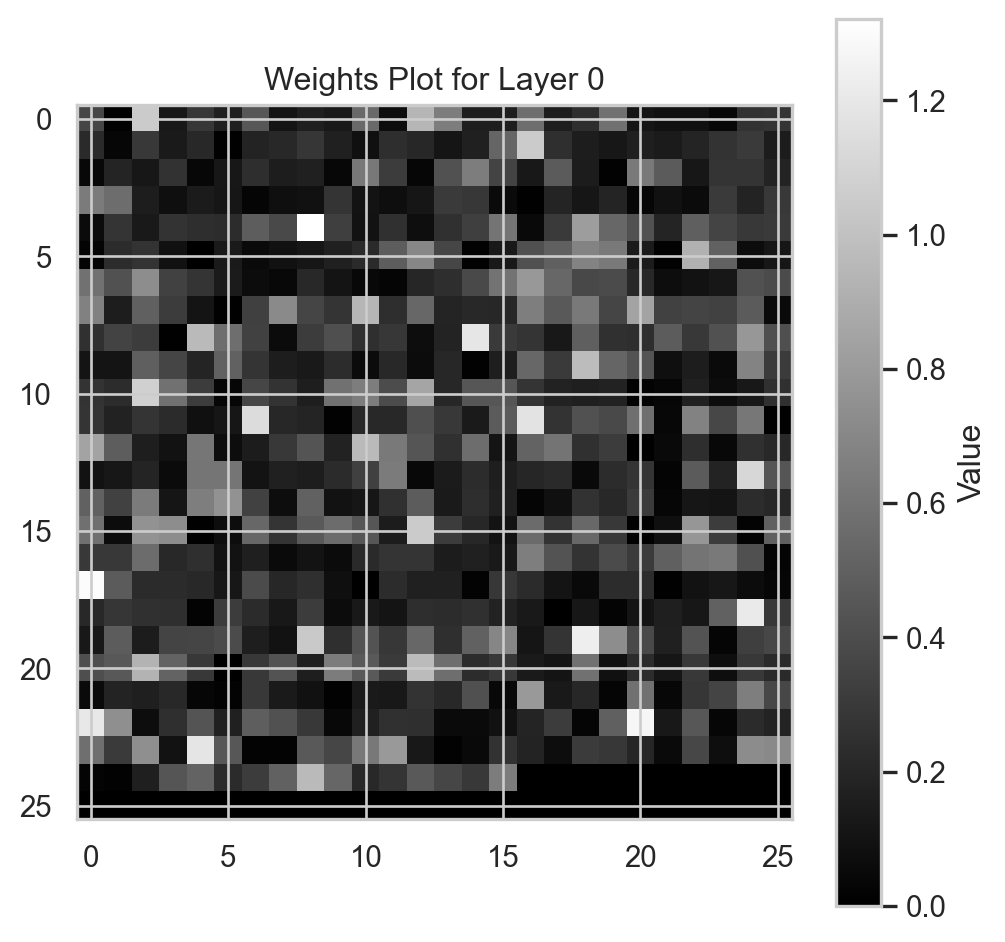

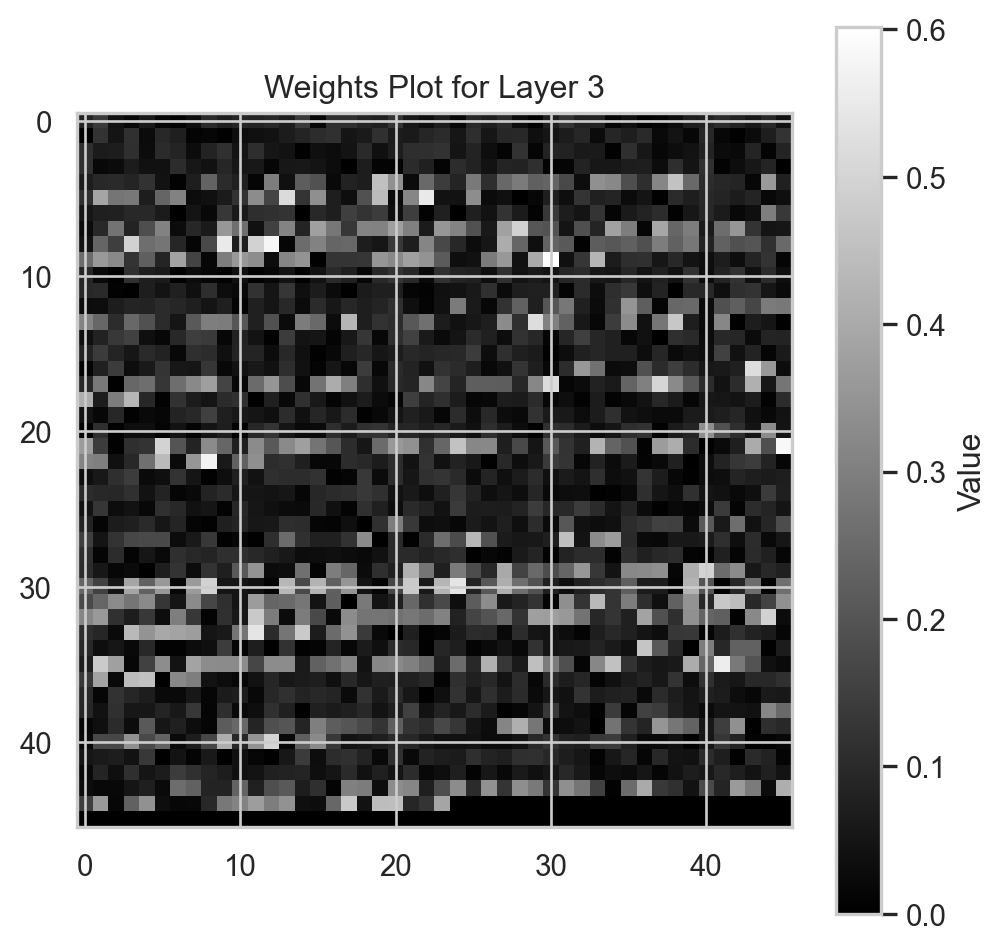

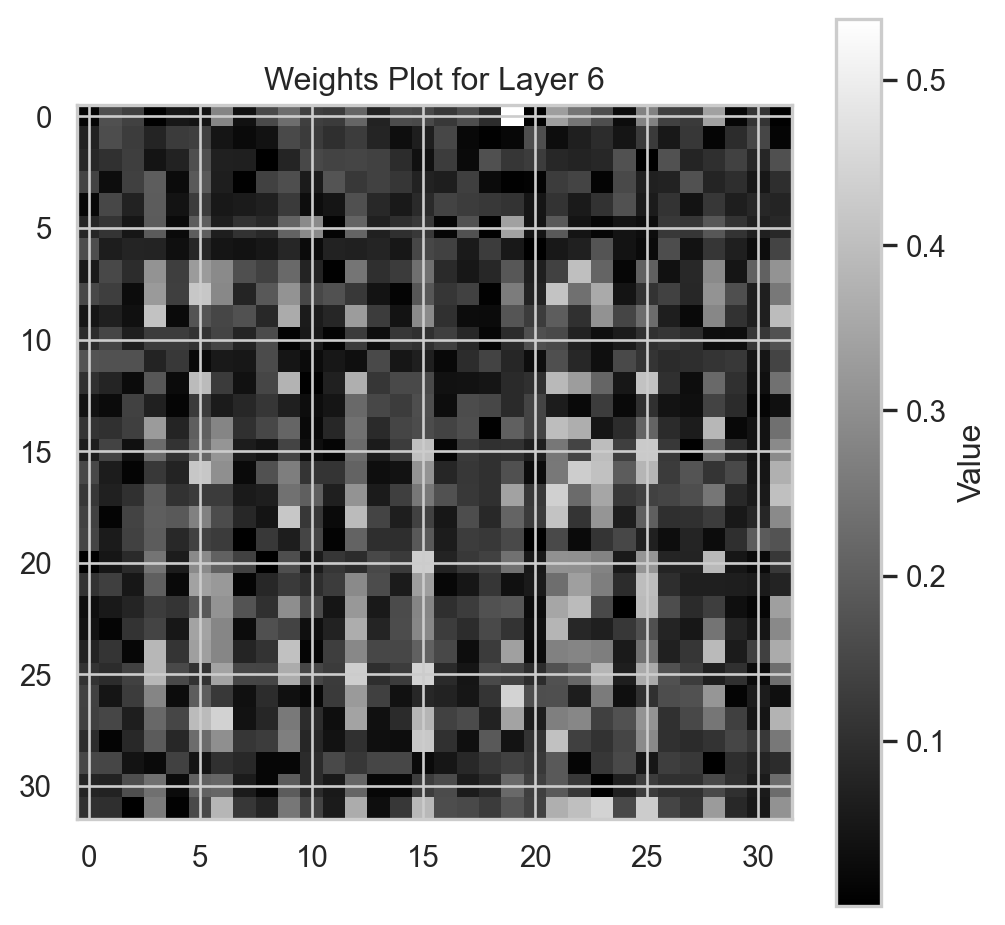

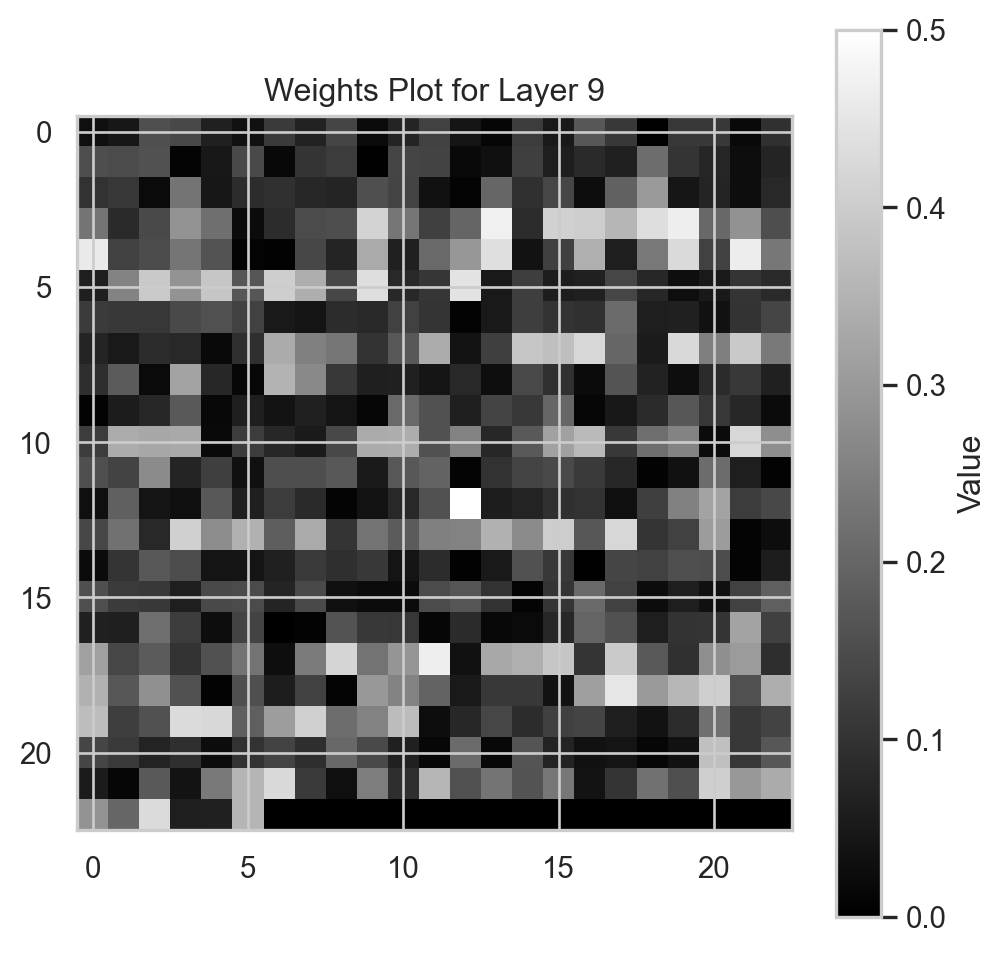

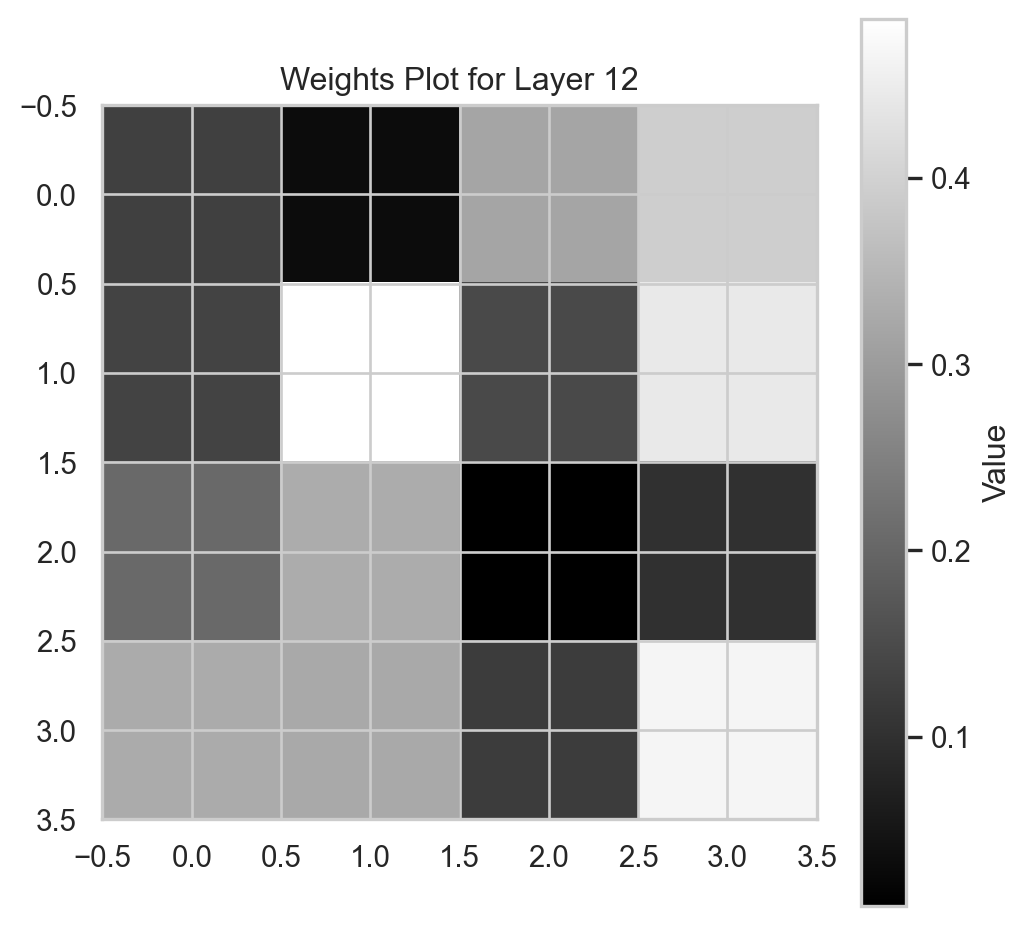

In [29]:
visualize_weights(model, absolute=True, cmap="gray", figsize=(6, 6))

n:5


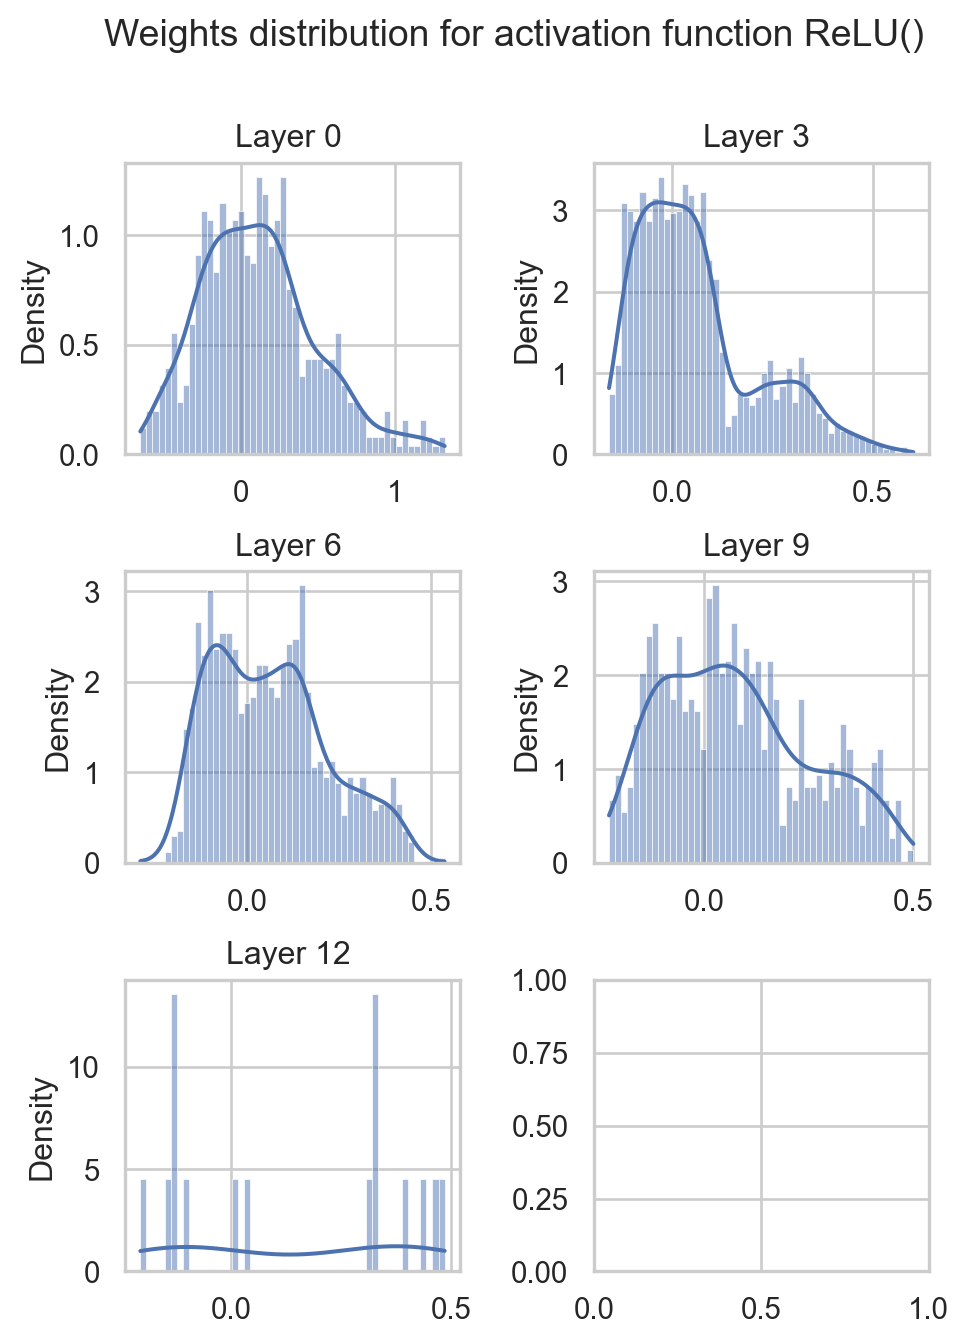

In [30]:
visualize_weights_distributions(model, color=f"C{0}")

### Activations


In [31]:
activations = get_activations(model, fun_control=fun_control, batch_size=batch_size, device = "cpu")

net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)


net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)


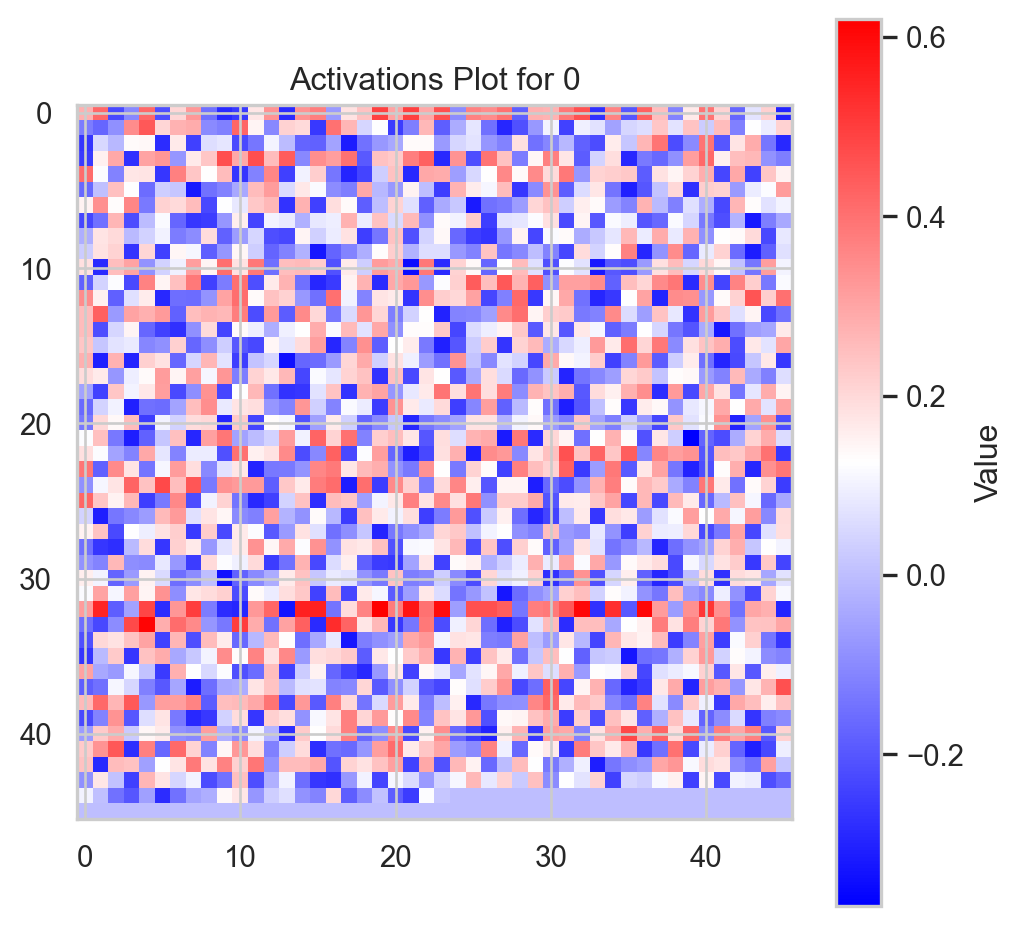

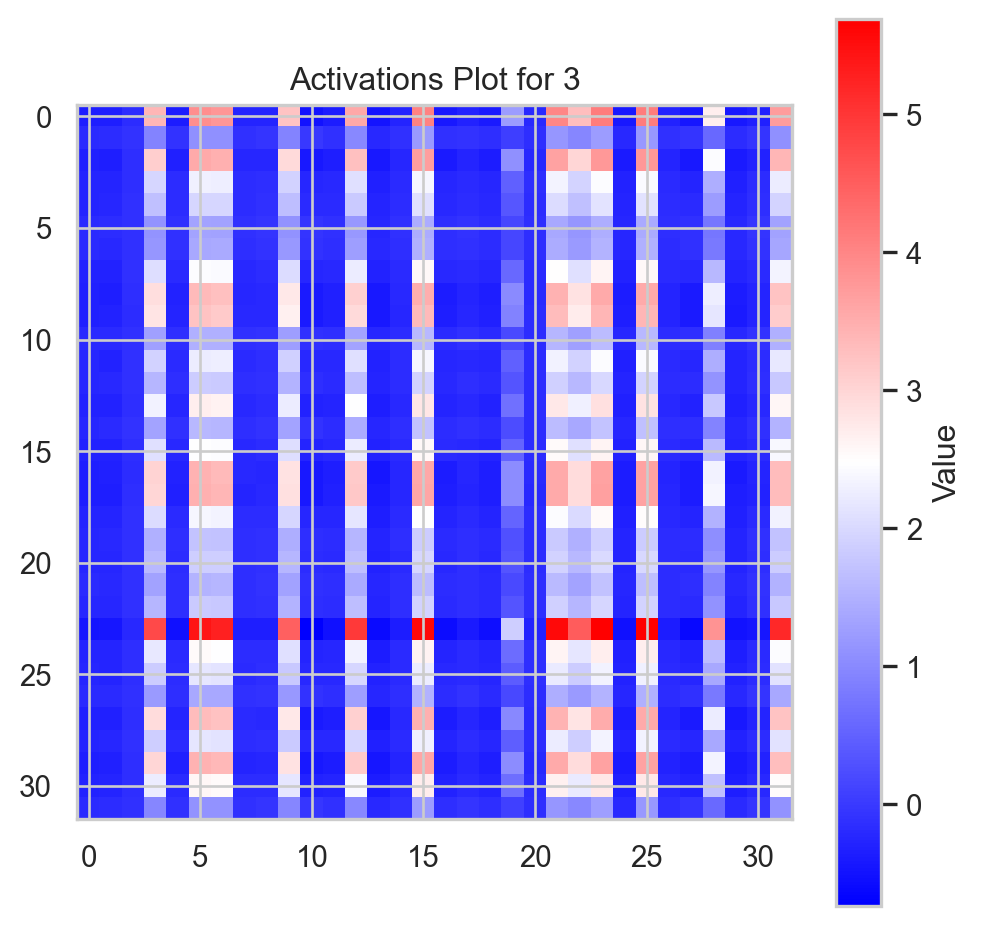

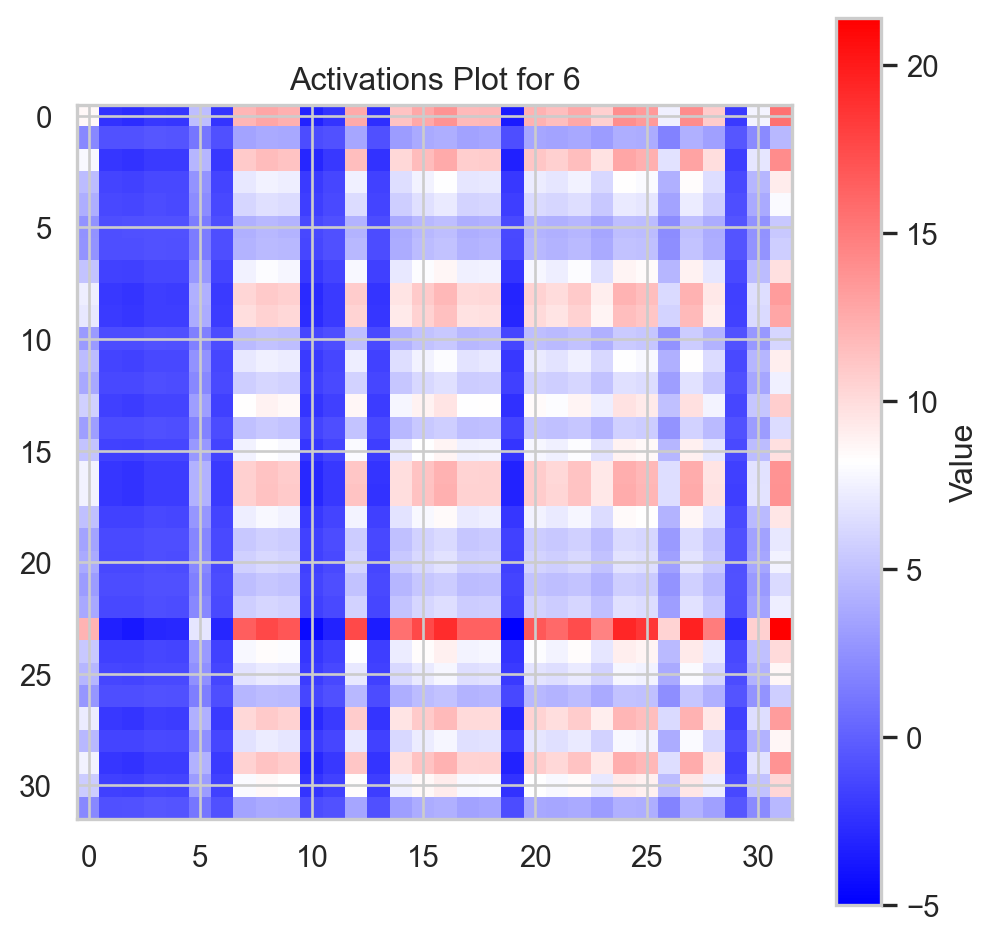

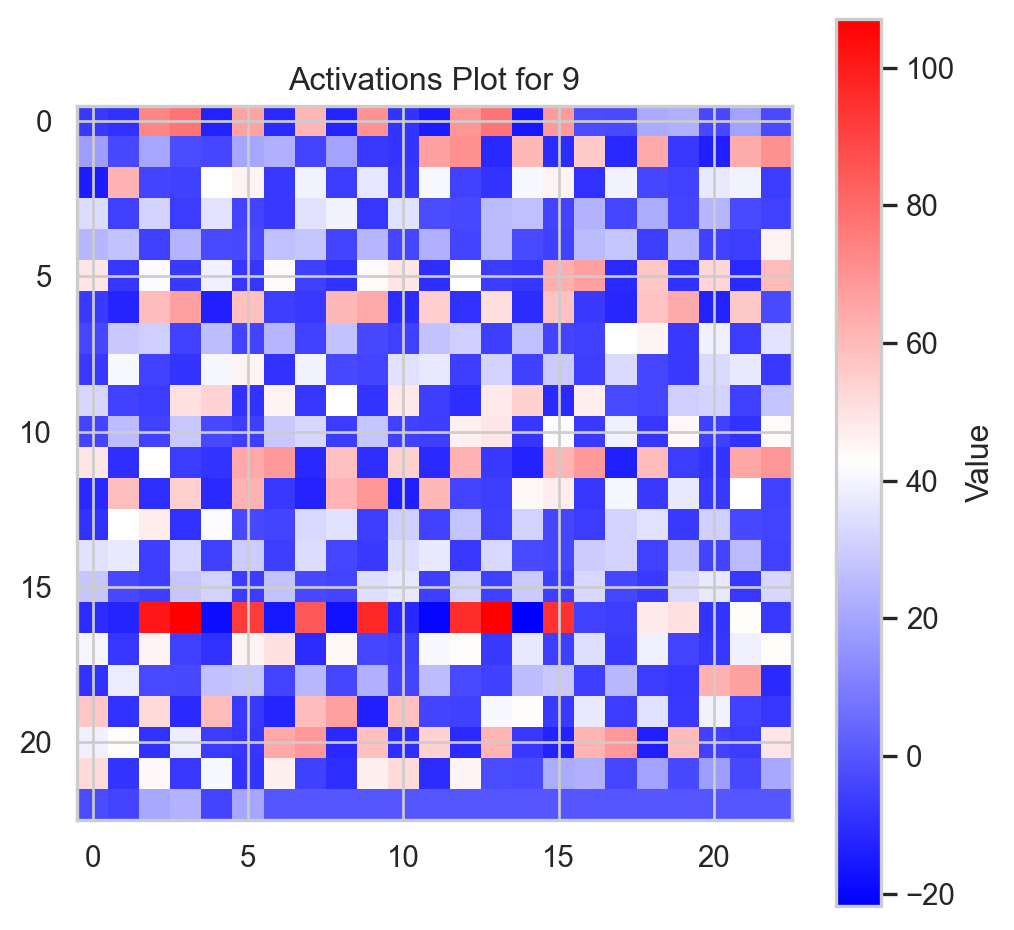

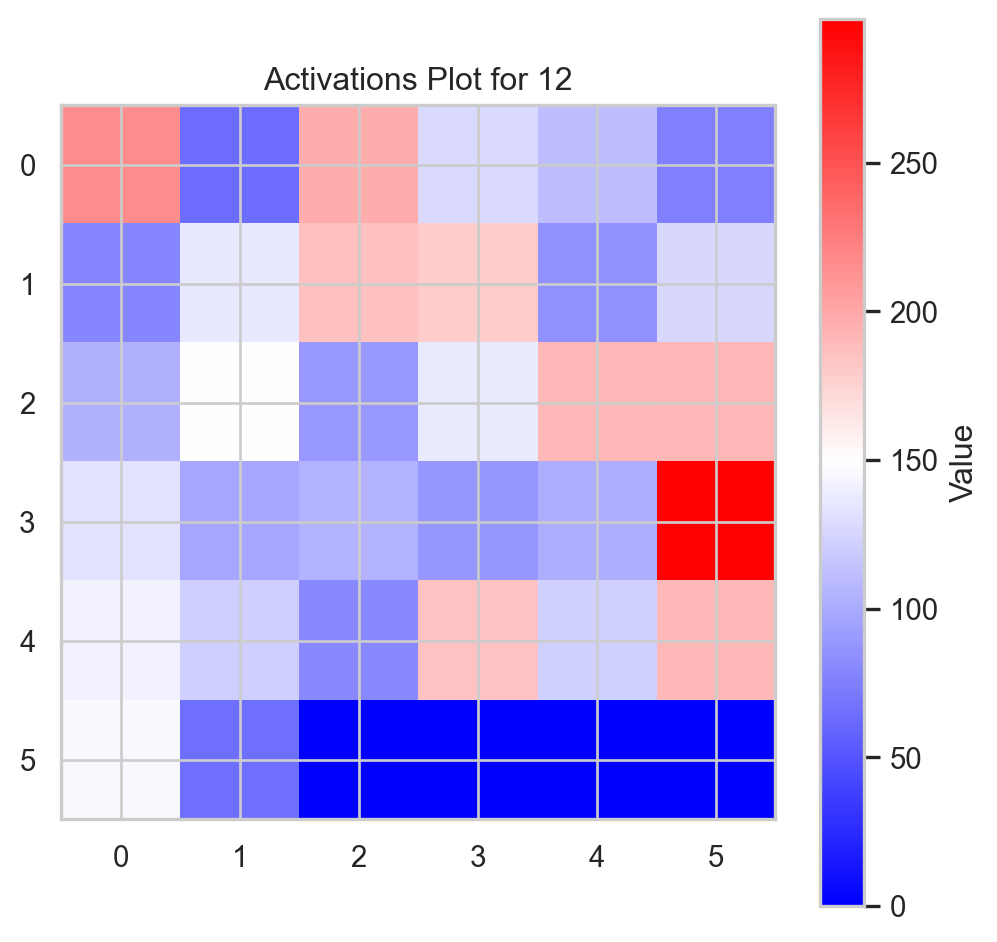

In [32]:
visualize_activations(model, fun_control=fun_control, batch_size=batch_size, device = "cpu", cmap="BlueWhiteRed", absolute=False)

* Absolute values of the activations are plotted:


net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)


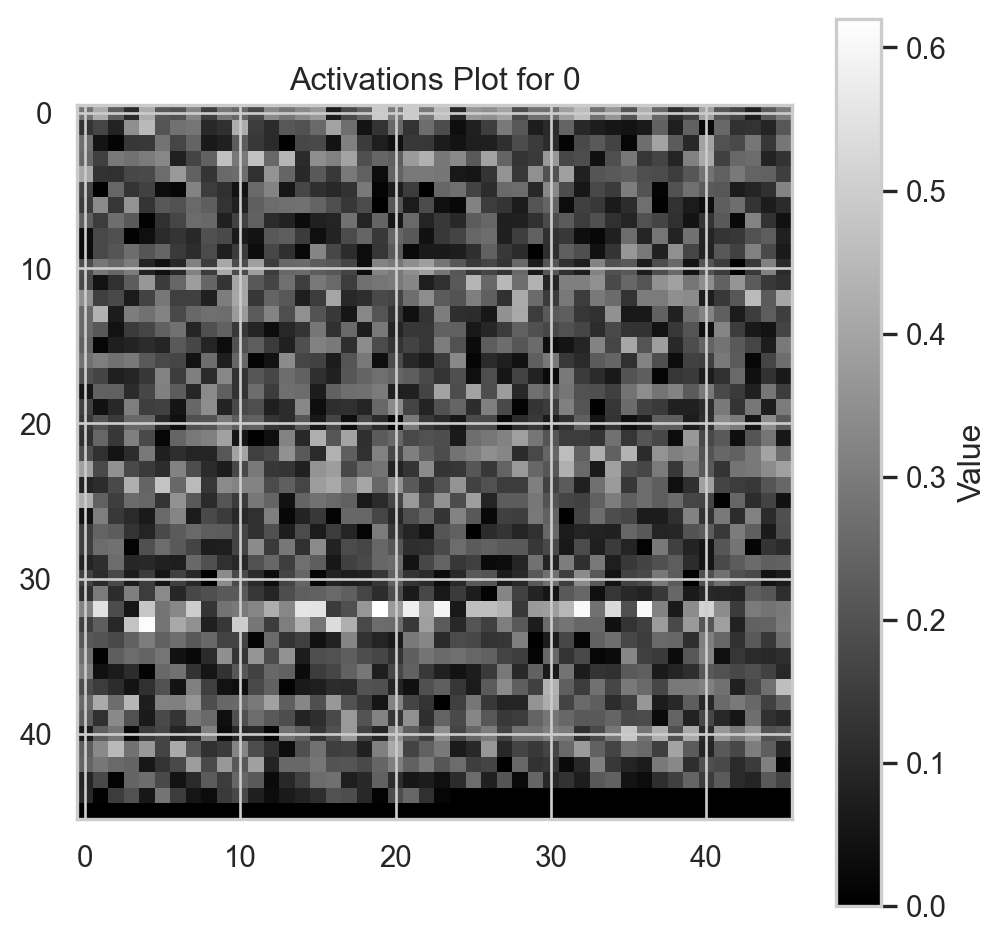

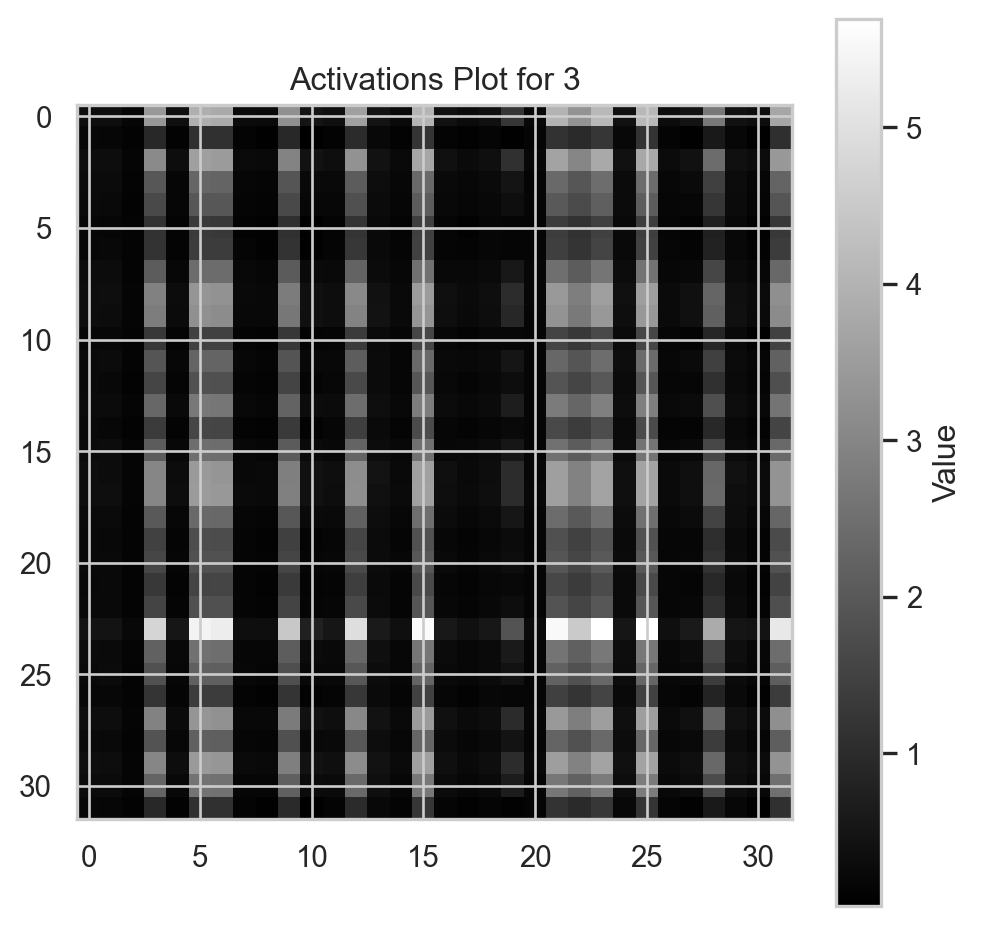

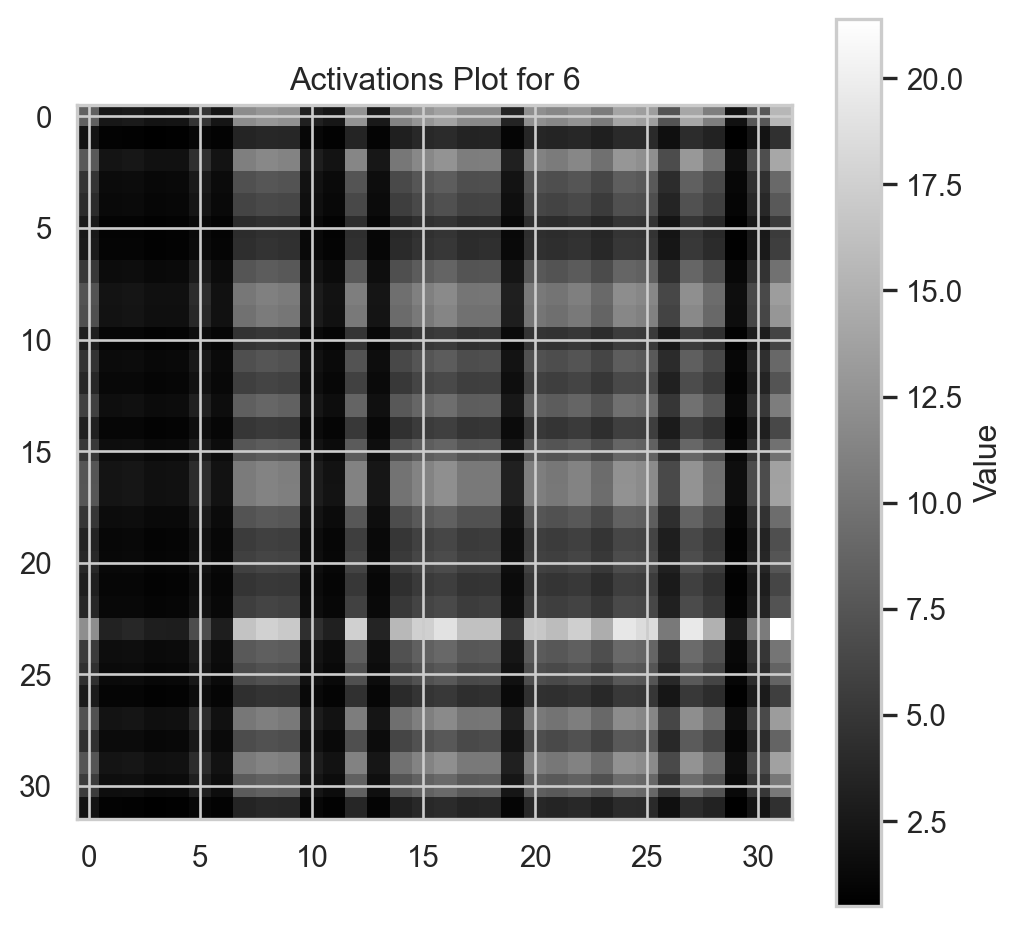

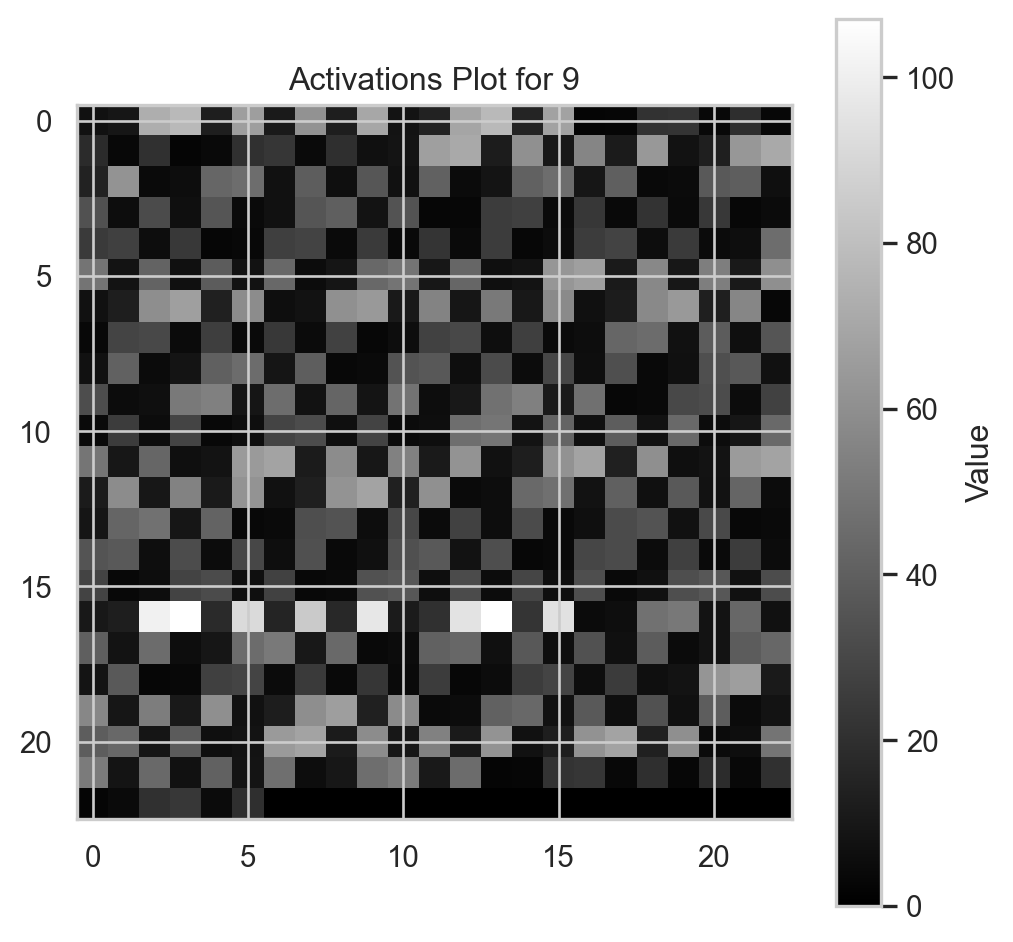

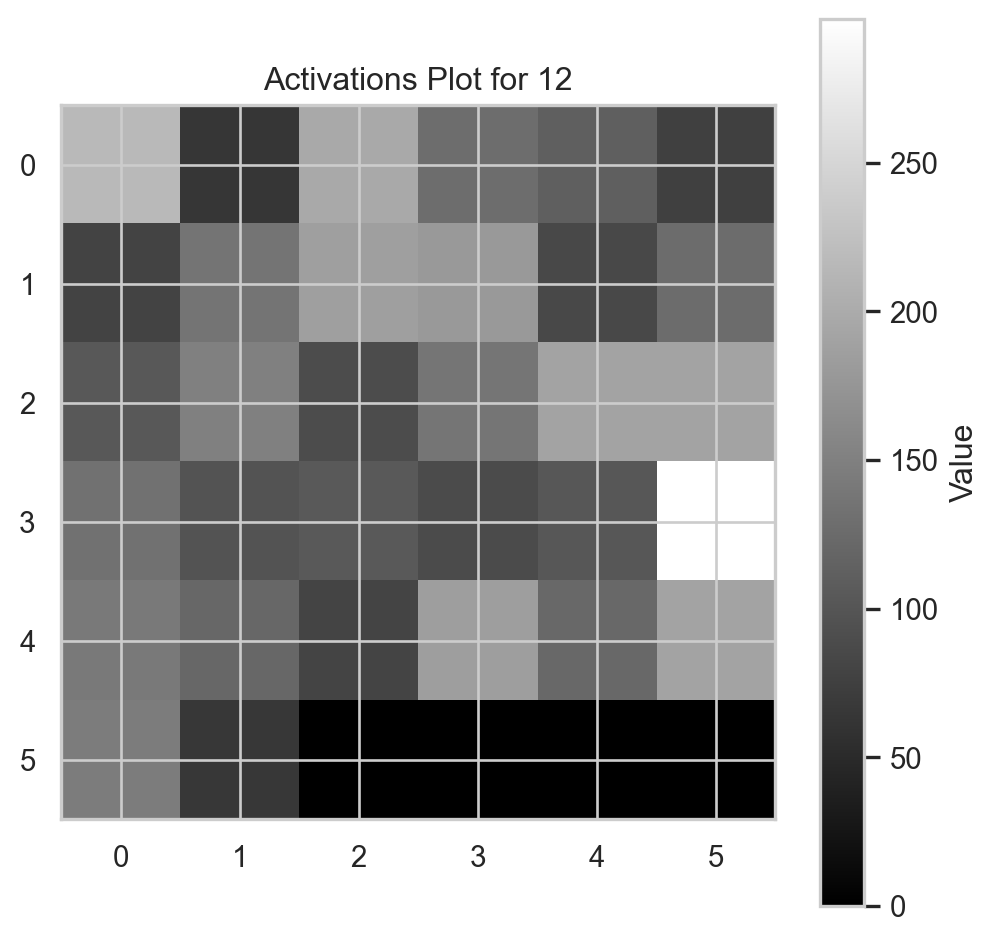

In [33]:
visualize_activations(model, fun_control=fun_control, batch_size=batch_size, device = "cpu", absolute=True)

net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)
n:5


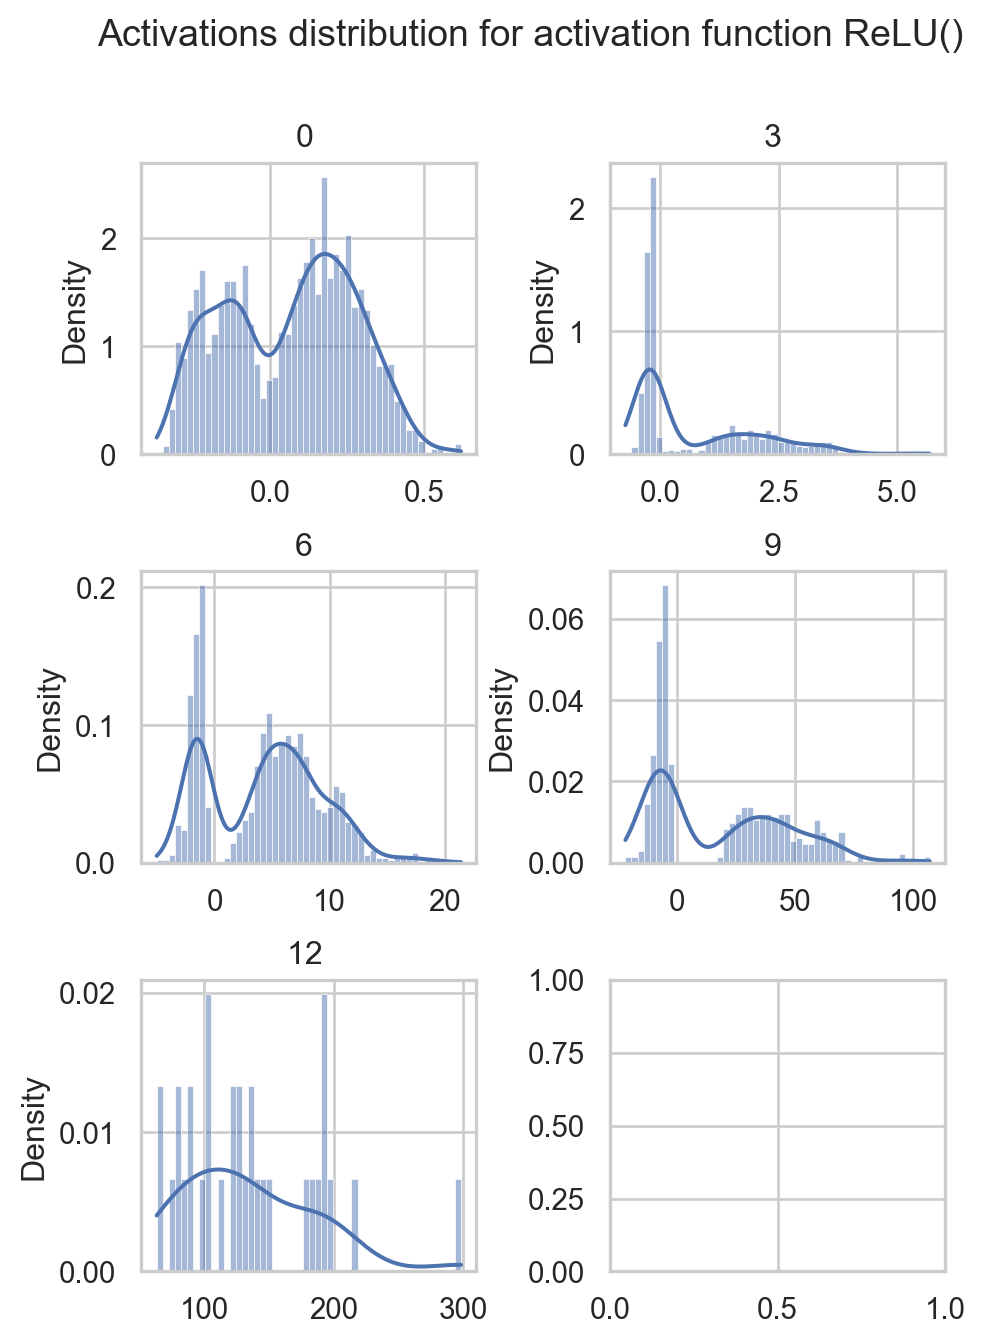

In [34]:
visualize_activations_distributions(net=model, fun_control=fun_control, batch_size=batch_size, device="cpu", color="C0", columns=2)

### Gradients


In [35]:
gradients = get_gradients(model, fun_control, batch_size, device="cpu")

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/spotPython/plot/xai.py:229: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



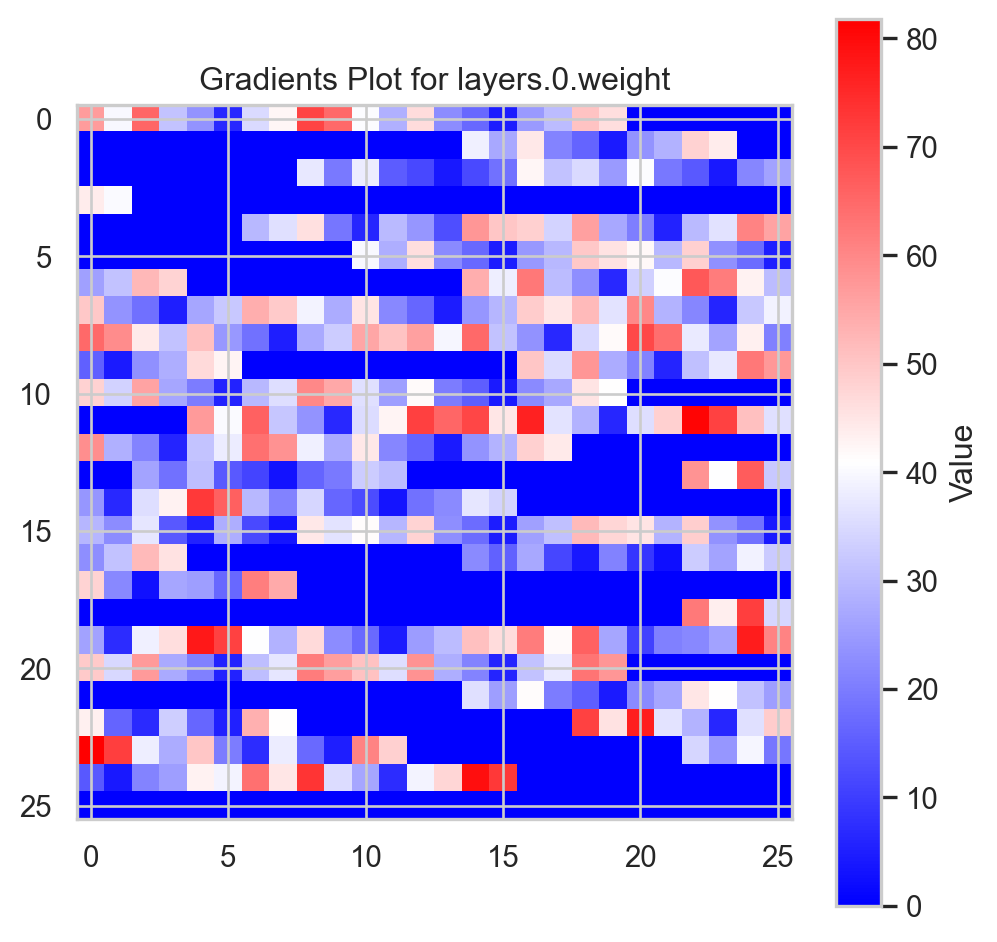

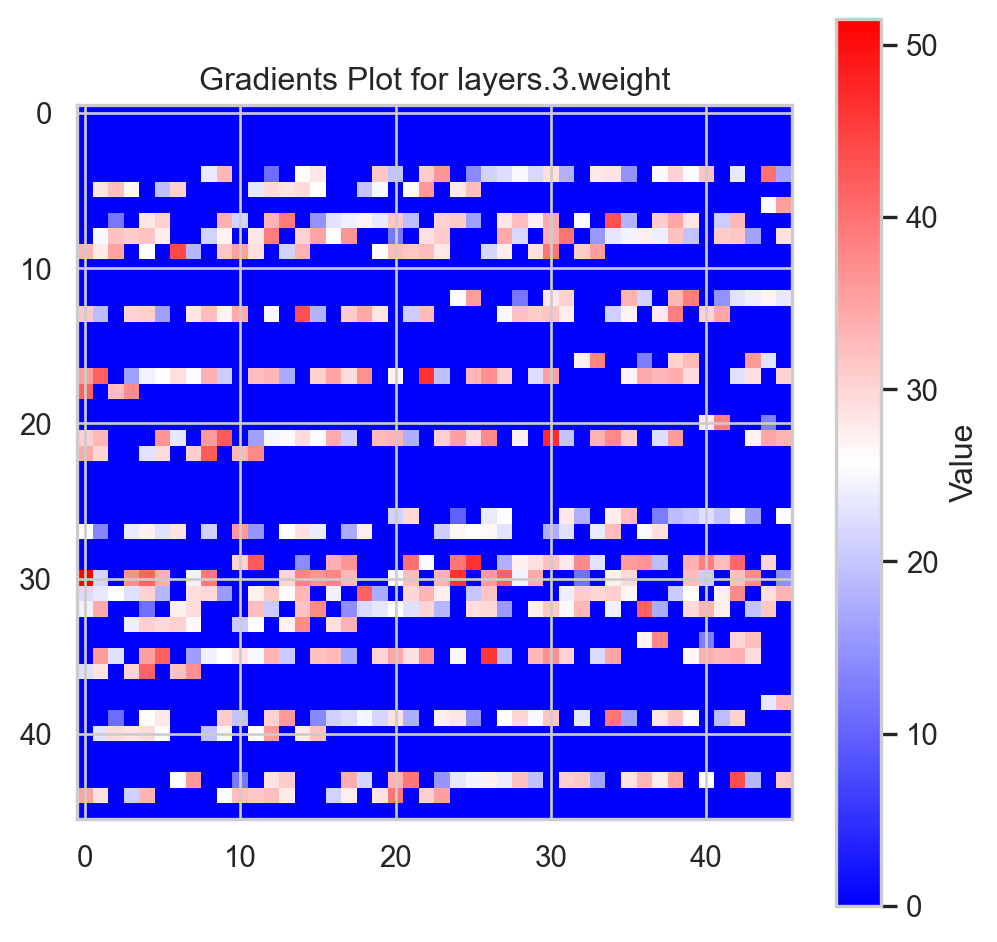

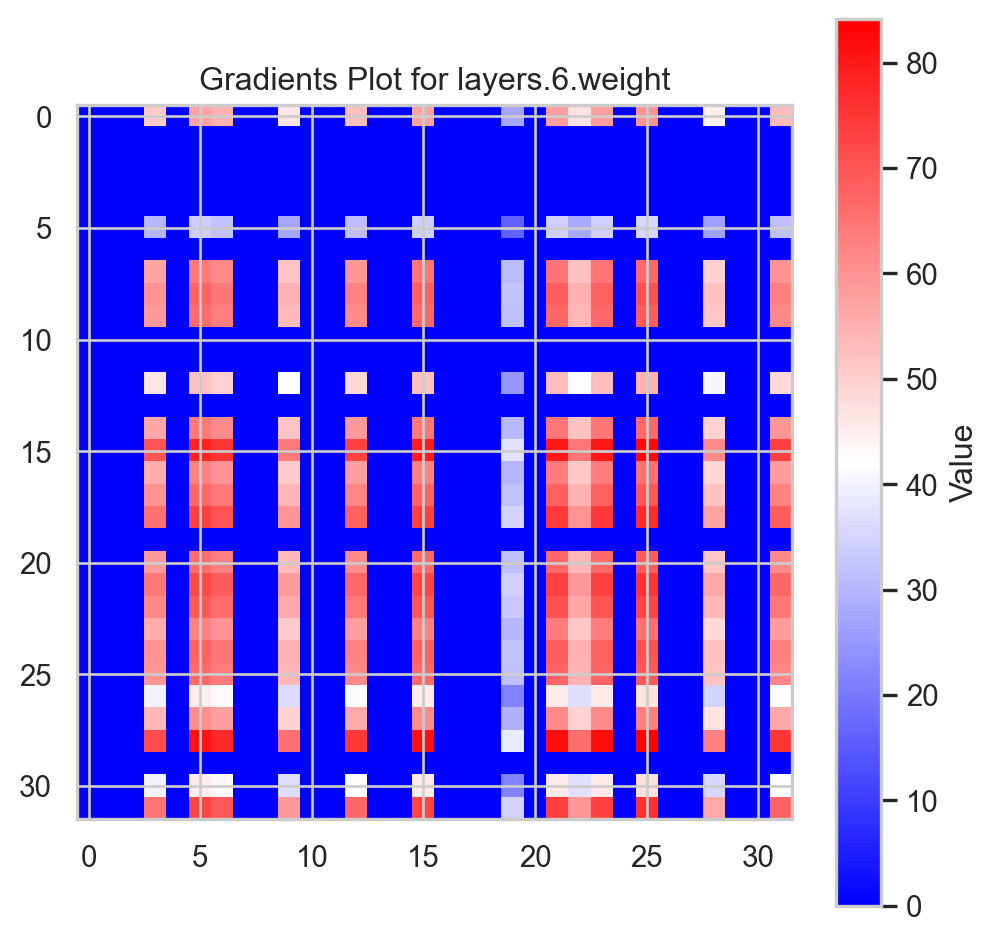

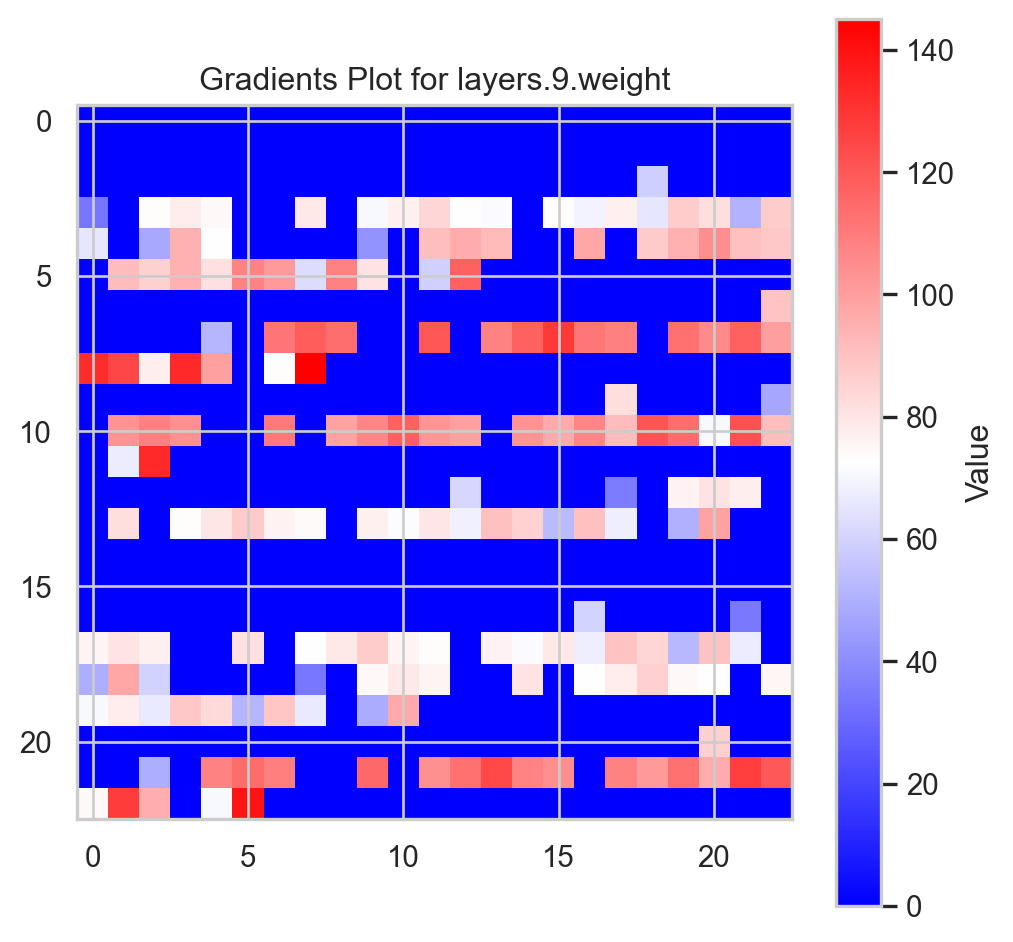

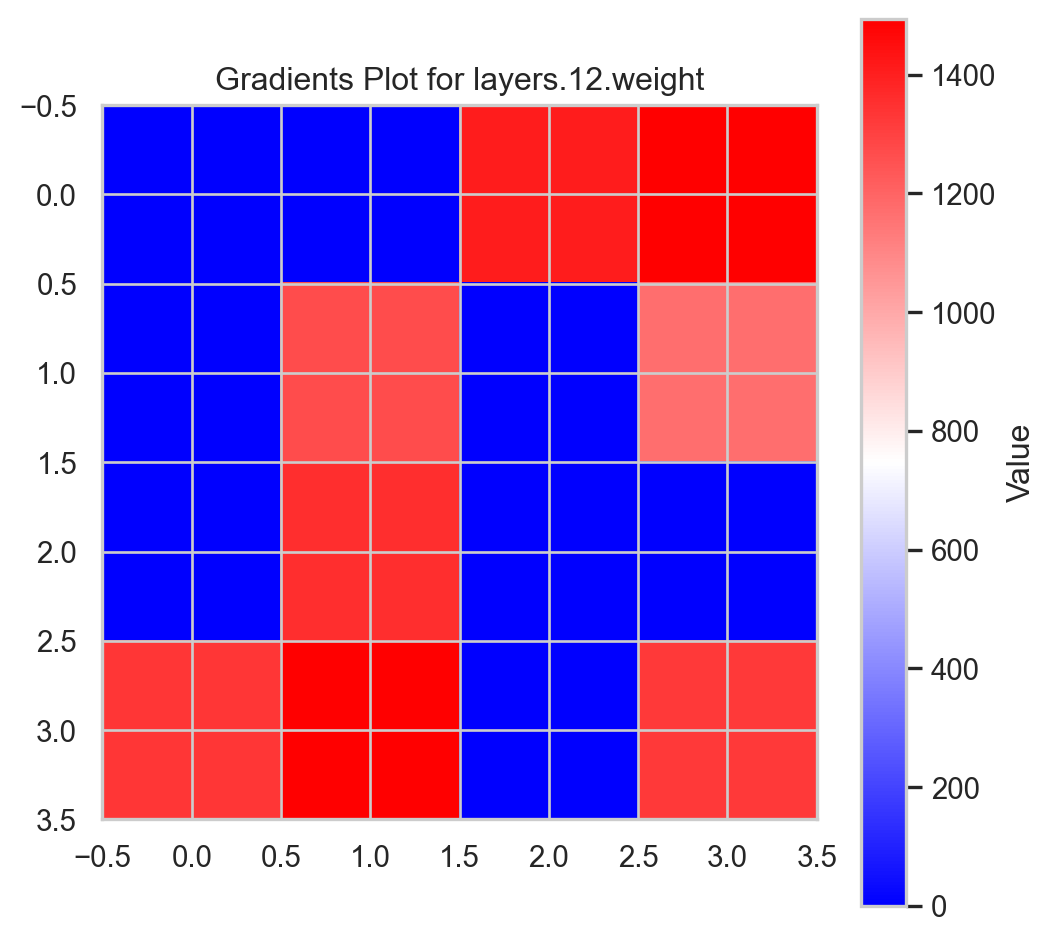

In [36]:
visualize_gradients(model, fun_control, batch_size, absolute=True, cmap="BlueWhiteRed", figsize=(6, 6))

n:5


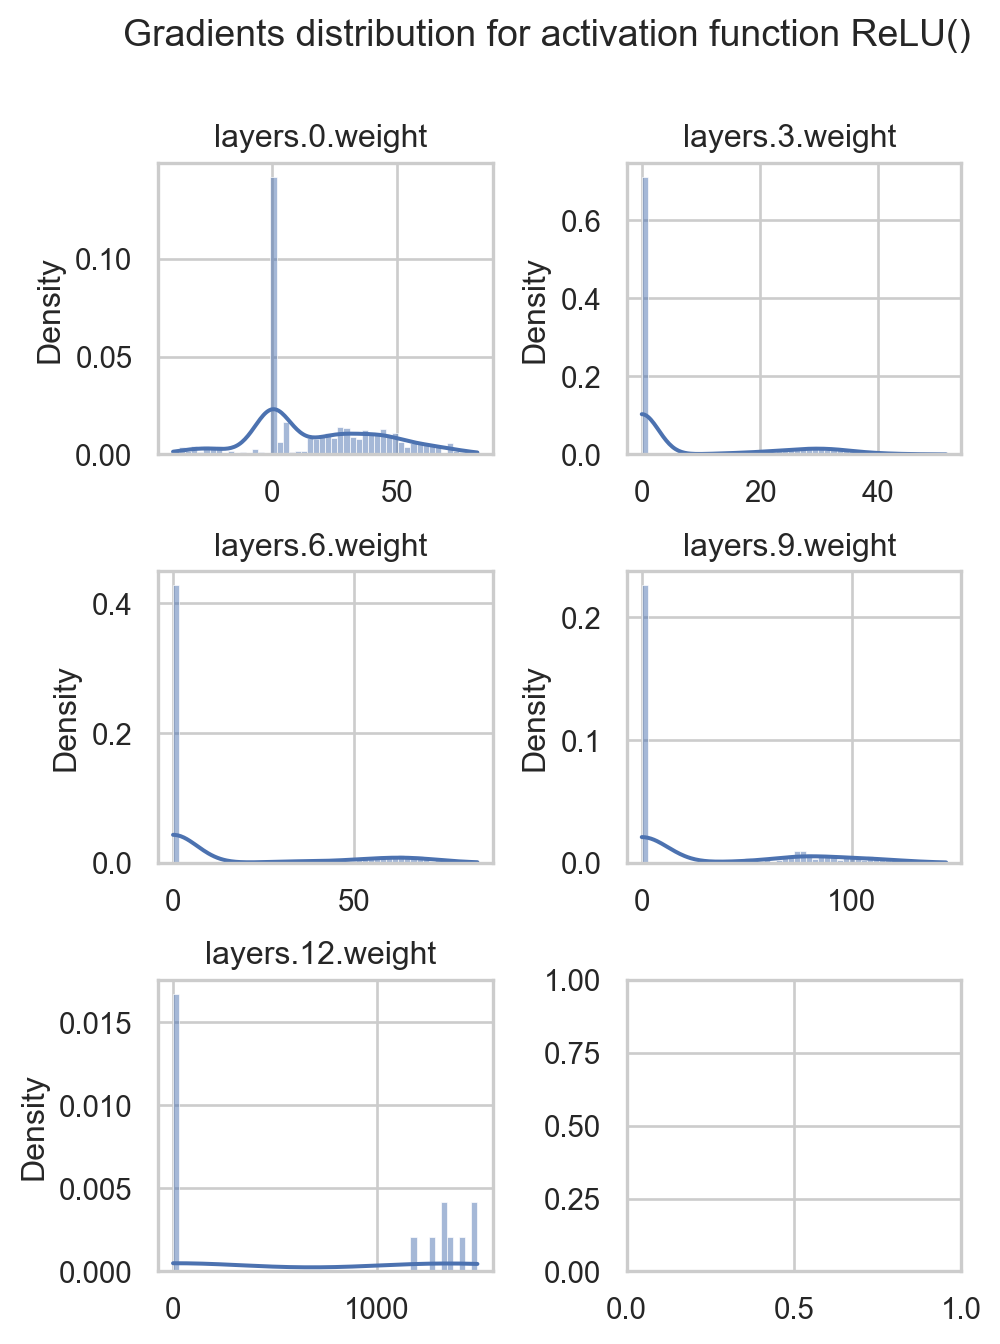

In [37]:
visualize_gradient_distributions(model, fun_control, batch_size=batch_size, color=f"C{0}")